# Base

In [1]:
import os
import time
import copy
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import optuna
import matplotlib.pyplot as plt
import logging

from einops import rearrange
from einops.layers.torch import Rearrange

# 設定log等級
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s: %(message)s')

# 設置設備
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

/root/anaconda3/envs/tf_env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda


# Path

In [2]:
# 請確保路徑皆正確存在，並且BCSSDataset可正確使用
TRAIN_IMAGE_PATH = 'archive/BCSS_512/train_512/'
VAL_IMAGE_PATH = 'archive/BCSS_512/val_512/'
TRAIN_MASK_PATH = 'archive/BCSS_512/train_mask_512/'
VAL_MASK_PATH = 'archive/BCSS_512/val_mask_512/'

# 從外部檔案載入 BCSSDataset 類別，請確認 bcss_dataset.py 存在且正確
from bcss_dataset import BCSSDataset

# 定義數據增強轉換
transforms_train = A.Compose([
    A.RandomResizedCrop(height=320, width=320, scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20),
    ], p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MotionBlur(blur_limit=(3, 7))
    ], p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

transforms_val = A.Compose([
    A.Resize(320, 320),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Attention

In [3]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // ratio, 1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // ratio, in_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = self.sigmoid(avg_out + max_out)
        return out * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return out * x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_attention=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.channel_attention = ChannelAttention(out_channels) if use_attention else nn.Identity()
        self.spatial_attention = SpatialAttention() if use_attention else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# UNet

In [4]:
class UNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=22):
        super(UNet, self).__init__()
        
        self.inc = ConvBlock(num_channels, 64, use_attention=False)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(64, 128, use_attention=False)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(128, 256, use_attention=False)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(256, 512, use_attention=False)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(512, 1024, use_attention=False)
        )
        
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(1024, 512, use_attention=False)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = ConvBlock(512, 256, use_attention=False)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = ConvBlock(256, 128, use_attention=False)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = ConvBlock(128, 64, use_attention=False)
        
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        
        return self.outc(x)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-7):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        predictions = F.softmax(predictions, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=predictions.size(1)).permute(0, 3, 1, 2).float()

        predictions_flat = predictions.view(predictions.size(0), predictions.size(1), -1)
        targets_flat = targets_one_hot.view(targets_one_hot.size(0), targets_one_hot.size(1), -1)

        intersection = (predictions_flat * targets_flat).sum(dim=-1)
        dice = (2. * intersection + self.smooth) / (
            predictions_flat.sum(dim=-1) + targets_flat.sum(dim=-1) + self.smooth
        )
        mean_dice = dice.mean(dim=1).mean()
        return 1 - mean_dice

# nnUNet

In [5]:
class nnUNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.InstanceNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(inplace=True)
        
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.InstanceNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        out = self.relu(out)
        return out

class nnUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=22, base_features=32):
        super().__init__()
        self.base_features = base_features
        
        self.enc1 = nnUNetBlock(num_channels, base_features)
        self.enc2 = nnUNetBlock(base_features, base_features*2, stride=2)
        self.enc3 = nnUNetBlock(base_features*2, base_features*4, stride=2)
        self.enc4 = nnUNetBlock(base_features*4, base_features*8, stride=2)
        self.enc5 = nnUNetBlock(base_features*8, base_features*16, stride=2)
        
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(base_features*16, base_features*8, kernel_size=2, stride=2),
            nnUNetBlock(base_features*16, base_features*8)
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(base_features*8, base_features*4, kernel_size=2, stride=2),
            nnUNetBlock(base_features*8, base_features*4)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(base_features*4, base_features*2, kernel_size=2, stride=2),
            nnUNetBlock(base_features*4, base_features*2)
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(base_features*2, base_features, kernel_size=2, stride=2),
            nnUNetBlock(base_features*2, base_features)
        )
        
        self.final = nn.Conv2d(base_features, num_classes, kernel_size=1)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        
        d4 = self.dec4[0](x5)
        d4 = torch.cat([d4, x4], dim=1)
        d4 = self.dec4[1](d4)
        
        d3 = self.dec3[0](d4)
        d3 = torch.cat([d3, x3], dim=1)
        d3 = self.dec3[1](d3)
        
        d2 = self.dec2[0](d3)
        d2 = torch.cat([d2, x2], dim=1)
        d2 = self.dec2[1](d2)
        
        d1 = self.dec1[0](d2)
        d1 = torch.cat([d1, x1], dim=1)
        d1 = self.dec1[1](d1)
        
        return self.final(d1)

# MultiResUNet

In [6]:
class MultiResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_channels = out_channels
        inter_channels = int(out_channels/6)
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
        
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True)
        )
        
        self.conv5x5 = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True)
        )
        
        self.conv7x7 = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(inter_channels * 3, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        identity = self.shortcut(x)
        
        a = self.conv3x3(x)
        b = self.conv5x5(x)
        c = self.conv7x7(x)
        
        x = torch.cat([a, b, c], dim=1)
        x = self.final_conv(x)
        
        return F.relu(x + identity)

class ResPath(nn.Module):
    def __init__(self, in_channels, out_channels, path_length):
        super().__init__()
        self.path_length = path_length
        
        self.first_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels)
            ) for _ in range(path_length)
        ])
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.first_conv(x)
        
        for layer in self.layers:
            shortcut = x
            x = layer(x)
            x = self.relu(x + shortcut)
        
        return x

class MultiResUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=22):
        super().__init__()
        
        filters = [32, 64, 128, 256, 512]
        
        self.enc1 = MultiResBlock(num_channels, filters[0])
        self.enc2 = MultiResBlock(filters[0], filters[1])
        self.enc3 = MultiResBlock(filters[1], filters[2])
        self.enc4 = MultiResBlock(filters[2], filters[3])
        
        self.respath1 = ResPath(filters[0], filters[0], 4)
        self.respath2 = ResPath(filters[1], filters[1], 3)
        self.respath3 = ResPath(filters[2], filters[2], 2)
        self.respath4 = ResPath(filters[3], filters[3], 1)
        
        self.pool = nn.MaxPool2d(2)
        self.center = MultiResBlock(filters[3], filters[4])
        
        self.up4 = nn.ConvTranspose2d(filters[4], filters[3], kernel_size=2, stride=2)
        self.dec4 = MultiResBlock(filters[3]*2, filters[3])
        
        self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
        self.dec3 = MultiResBlock(filters[2]*2, filters[2])
        
        self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
        self.dec2 = MultiResBlock(filters[1]*2, filters[1])
        
        self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
        self.dec1 = MultiResBlock(filters[0]*2, filters[0])
        
        self.final = nn.Conv2d(filters[0], num_classes, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc1_res = self.respath1(enc1)
        
        enc2 = self.enc2(self.pool(enc1))
        enc2_res = self.respath2(enc2)
        
        enc3 = self.enc3(self.pool(enc2))
        enc3_res = self.respath3(enc3)
        
        enc4 = self.enc4(self.pool(enc3))
        enc4_res = self.respath4(enc4)
        
        center = self.center(self.pool(enc4))
        
        dec4 = self.up4(center)
        dec4 = torch.cat([dec4, enc4_res], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.up3(dec4)
        dec3 = torch.cat([dec3, enc3_res], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.up2(dec3)
        dec2 = torch.cat([dec2, enc2_res], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.up1(dec2)
        dec1 = torch.cat([dec1, enc1_res], dim=1)
        dec1 = self.dec1(dec1)
        
        return self.final(dec1)

# TransUNet

In [7]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, 
                 drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, 
                                           attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class TransUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=22, embed_dim=768, depth=12, 
                 num_heads=12, mlp_ratio=4., qkv_bias=True, drop_rate=0.1,
                 image_size=320):
        super().__init__()
        
        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.patch_size = 16
        patches_size = (image_size // 4 // self.patch_size) ** 2
        
        self.patch_embed = nn.Sequential(
            nn.Conv2d(64, embed_dim, kernel_size=self.patch_size, stride=self.patch_size),
            Rearrange('b c h w -> b (h w) c'),
            nn.LayerNorm(embed_dim)
        )
        
        self.pos_embed = nn.Parameter(torch.zeros(1, patches_size, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=drop_rate
            )
            for _ in range(depth)
        ])
        
        self.decoder_channels = (256, 128, 64, 32)
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(embed_dim if i == 0 else self.decoder_channels[i-1],
                                   self.decoder_channels[i],
                                   kernel_size=2,
                                   stride=2),
                nn.BatchNorm2d(self.decoder_channels[i]),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.decoder_channels[i], self.decoder_channels[i],
                          kernel_size=3, padding=1),
                nn.BatchNorm2d(self.decoder_channels[i]),
                nn.ReLU(inplace=True)
            )
            for i in range(4)
        ])
        
        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.cnn_encoder(x)
        x = self.patch_embed(x)
        x = self.pos_drop(x + self.pos_embed)
        
        for block in self.transformer_blocks:
            x = block(x)
            
        B, N, C = x.shape
        H = W = int(N ** 0.5)
        x = x.transpose(1, 2).reshape(B, C, H, W)
        
        for decoder_block in self.decoder:
            x = decoder_block(x)
            
        x = self.final_conv(x)
        x = F.interpolate(x, size=(320, 320), mode='bilinear', align_corners=True)
        
        return x

# Swin-UNet

In [8]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] * window_size * window_size / (H * W))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        assert self.head_dim * num_heads == dim, "dim must be divisible by num_heads"

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))
        
        coords = torch.stack(torch.meshgrid([torch.arange(window_size), 
                                             torch.arange(window_size)], indexing='ij'))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size - 1
        relative_coords[:, :, 1] += window_size - 1
        relative_coords[:, :, 0] *= 2 * window_size - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size * self.window_size, self.window_size * self.window_size, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size=10, shift_size=0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, window_size=window_size, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )

    def forward(self, x):
        H, W = x.shape[1], x.shape[2]
        
        shortcut = x
        x = self.norm1(x)

        # shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, self.dim)

        attn_windows = self.attn(x_windows)

        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, self.dim)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x

class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.reduction = nn.Linear(4 * in_channels, out_channels, bias=False)
        self.norm = nn.LayerNorm(4 * in_channels)

    def forward(self, x):
        h, w = x.shape[1], x.shape[2]
        assert h % 2 == 0 and w % 2 == 0
        
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3], -1)
        
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpanding(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.expand = nn.Linear(in_channels, out_channels * 4, bias=False)
        self.norm = nn.LayerNorm(out_channels * 4)

    def forward(self, x):
        x = self.expand(x)
        x = self.norm(x)
        
        B, H, W, C4 = x.shape
        x = x.reshape(B, H, W, 4, C4 // 4)
        x = x.permute(0, 1, 3, 2, 4)
        x = x.reshape(B, H * 2, W * 2, C4 // 4)
        return x

class SwinUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=22, embed_dim=96, 
                 depths=(2, 2, 6, 2), num_heads=(3, 6, 12, 24),
                 window_size=10, patch_size=4, image_size=320):
        super().__init__()
        
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.window_size = window_size
        
        self.patch_embed = nn.Sequential(
            nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size),
            Rearrange('b c h w -> b h w c'),
            nn.LayerNorm(embed_dim)
        )
        
        self.encoder_layers = nn.ModuleList()
        dims = [embed_dim * (2 ** i) for i in range(len(depths))]
        
        for i in range(len(depths)):
            stage = nn.ModuleList([
                SwinTransformerBlock(
                    dim=dims[i],
                    num_heads=num_heads[i],
                    window_size=window_size,
                    shift_size=0 if (j % 2 == 0) else window_size // 2
                )
                for j in range(depths[i])
            ])
            self.encoder_layers.append(stage)
            if i < len(depths) - 1:
                self.encoder_layers.append(PatchMerging(dims[i], dims[i+1]))
        
        self.decoder_layers = nn.ModuleList()
        for i in range(len(depths)-1, -1, -1):
            if i > 0:
                self.decoder_layers.append(PatchExpanding(dims[i], dims[i-1]))
            stage = nn.ModuleList([
                SwinTransformerBlock(
                    dim=dims[max(0, i-1)],
                    num_heads=num_heads[max(0, i-1)],
                    window_size=window_size,
                    shift_size=0 if (j % 2 == 0) else window_size // 2
                )
                for j in range(depths[i])
            ])
            self.decoder_layers.append(stage)
        
        self.final_conv = nn.Sequential(
            Rearrange('b h w c -> b c h w'),
            nn.Conv2d(embed_dim, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        features = []
        
        # Encoder
        for layer in self.encoder_layers:
            if isinstance(layer, nn.ModuleList):
                for block in layer:
                    x = block(x)
            else:
                features.append(x)
                x = layer(x)
        
        # Decoder
        for i, layer in enumerate(self.decoder_layers):
            if isinstance(layer, PatchExpanding):
                x = layer(x)
                if features:
                    x = x + features.pop()
            else:
                for block in layer:
                    x = block(x)
        
        x = self.final_conv(x)
        
        if x.size(-1) != 320 or x.size(-2) != 320:
            x = F.interpolate(x, size=(320, 320), mode='bilinear', align_corners=True)
        
        return x

# DenseUNet

In [9]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(4 * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        return torch.cat([x, self.layers(x)], 1)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([
            DenseLayer(in_channels + i * growth_rate, growth_rate)
            for i in range(num_layers)
        ])
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.layers(x)

class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_channels, out_channels,
            kernel_size=3, stride=2, padding=1, output_padding=1, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.convTrans(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DenseUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=22, growth_rate=32, 
                 block_config=(4, 4, 4, 4, 4), init_features=64):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(num_channels, init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        channels = init_features
        self.encoder_blocks = nn.ModuleList()
        self.skip_connections_channels = []
        self.transition_downs = nn.ModuleList()

        for i, num_layers in enumerate(block_config):
            block = DenseBlock(channels, growth_rate, num_layers)
            self.encoder_blocks.append(block)
            channels += num_layers * growth_rate
            self.skip_connections_channels.append(channels)
            
            if i != len(block_config) - 1:
                td = TransitionDown(channels, channels // 2)
                self.transition_downs.append(td)
                channels = channels // 2

        self.decoder_blocks = nn.ModuleList()
        self.transition_ups = nn.ModuleList()
        
        for i in range(len(block_config)-2, -1, -1):
            tu = TransitionUp(channels, self.skip_connections_channels[i])
            self.transition_ups.append(tu)
            
            decoder_channels = 2 * self.skip_connections_channels[i]
            block = DenseBlock(decoder_channels, growth_rate, block_config[i])
            self.decoder_blocks.append(block)
            channels = decoder_channels + block_config[i] * growth_rate
        
        self.final_conv = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, num_classes, kernel_size=1, bias=False)
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = self.features(x)
        encoder_features = []
        
        td_index = 0
        for i, block in enumerate(self.encoder_blocks):
            x = block(x)
            encoder_features.append(x)
            if i < len(self.transition_downs):
                x = self.transition_downs[i](x)
        
        for i in range(len(self.decoder_blocks)):
            skip_feat = encoder_features[-(i+2)]
            
            x = self.transition_ups[i](x)
            x = torch.cat([x, skip_feat], dim=1)
            x = self.decoder_blocks[i](x)

        x = self.final_conv(x)
        
        if x.size(-1) != 320 or x.size(-2) != 320:
            x = F.interpolate(x, size=(320, 320), mode='bilinear', align_corners=True)
        return x

# Training & Evaluation

In [10]:
def calculate_iou(outputs, targets, num_classes=22):
    outputs = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    ious = []
    for c in range(num_classes):
        pred_c = (outputs == c)
        target_c = (targets == c)
        intersection = (pred_c & target_c).sum()
        union = (pred_c | target_c).sum()
        if union == 0:
            iou_c = torch.tensor(1.0, device=outputs.device)
        else:
            iou_c = intersection.float() / union.float()
        ious.append(iou_c)
    return torch.mean(torch.stack(ious)).item()

def calculate_dice(outputs, targets, smooth=1e-6):
    outputs = F.softmax(outputs, dim=1)
    targets_one_hot = F.one_hot(targets, num_classes=outputs.size(1)).permute(0, 3, 1, 2).float()

    outputs_flat = outputs.view(outputs.size(0), outputs.size(1), -1)
    targets_flat = targets_one_hot.view(targets_one_hot.size(0), targets_one_hot.size(1), -1)

    intersection = (outputs_flat * targets_flat).sum(dim=-1)
    dice = (2. * intersection + smooth) / (outputs_flat.sum(dim=-1) + targets_flat.sum(dim=-1) + smooth)
    return dice.mean(dim=1).mean().item()

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_model = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            self.status = f'EarlyStopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                self.status = f'EarlyStopping triggered'
                if self.restore_best_weights and self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        else:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f'EarlyStopping counter reset'
        return False

class ModelTrainer:
    def __init__(self, model_name, model, train_loader, val_loader, criterion, 
                optimizer, scheduler, device, num_epochs=100):
        self.model_name = model_name
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs
        self.early_stopping = EarlyStopping(patience=8)
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_iou': [], 'val_iou': [],
            'train_dice': [], 'val_dice': [],
            'train_acc': [], 'val_acc': [],
            'learning_rates': []
        }

    def calculate_accuracy(self, outputs, masks):
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == masks).float()
        accuracy = correct.sum() / correct.numel()
        return accuracy.item()

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        total_iou = 0
        total_dice = 0
        total_acc = 0
        
        pbar = tqdm(self.train_loader, desc=f'Training {self.model_name}')
        for images, masks in pbar:
            images = images.to(self.device)
            masks = masks.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, masks)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            iou = calculate_iou(outputs, masks)
            dice = calculate_dice(outputs, masks)
            acc = self.calculate_accuracy(outputs, masks)
            
            total_iou += iou
            total_dice += dice
            total_acc += acc
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'iou': f'{iou:.4f}',
                'dice': f'{dice:.4f}',
                'acc': f'{acc:.4f}'
            })
        
        return (total_loss / len(self.train_loader), 
                total_iou / len(self.train_loader), 
                total_dice / len(self.train_loader),
                total_acc / len(self.train_loader))

    def validate(self):
        self.model.eval()
        total_loss = 0
        total_iou = 0
        total_dice = 0
        total_acc = 0
        
        with torch.no_grad():
            for images, masks in tqdm(self.val_loader, desc='Validating'):
                images = images.to(self.device)
                masks = masks.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                
                total_loss += loss.item()
                total_iou += calculate_iou(outputs, masks)
                total_dice += calculate_dice(outputs, masks)
                total_acc += self.calculate_accuracy(outputs, masks)
        
        return (total_loss / len(self.val_loader), 
                total_iou / len(self.val_loader), 
                total_dice / len(self.val_loader),
                total_acc / len(self.val_loader))

    def train(self):
        best_iou = 0
        start_time = time.time()
        
        for epoch in range(self.num_epochs):
            print(f'\nEpoch {epoch+1}/{self.num_epochs}')
            
            train_loss, train_iou, train_dice, train_acc = self.train_epoch()
            val_loss, val_iou, val_dice, val_acc = self.validate()
            
            if self.scheduler is not None:
                self.scheduler.step()
            
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_iou'].append(train_iou)
            self.history['val_iou'].append(val_iou)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])
            
            print(f'Train - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}, Acc: {train_acc:.4f}')
            print(f'Val   - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Dice: {val_dice:.4f}, Acc: {val_acc:.4f}')
            
            if self.early_stopping(self.model, val_loss):
                print("Early stopping triggered!")
                break
            
            if val_iou > best_iou:
                best_iou = val_iou
                print(f'New best model with IoU: {best_iou:.4f}')
        
        training_time = time.time() - start_time
        print(f'\nTraining completed in {training_time/60:.2f} minutes')
        return self.history, training_time

# Visualization

In [11]:
def run_comparison(train_loader, val_loader, device):
    models = {
        'UNet': UNet(num_channels=3, num_classes=22),
        'nnUNet': nnUNet(num_channels=3, num_classes=22),
        'MultiResUNet': MultiResUNet(num_channels=3, num_classes=22),
        'TransUNet': TransUNet(num_channels=3, num_classes=22),
        'SwinUNet': SwinUNet(num_channels=3, num_classes=22),
        'DenseUNet': DenseUNet(num_channels=3, num_classes=22)
    }
    
    results = {}
    training_params = {
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
    }
    
    for name, model in models.items():
        print(f'\nTraining {name}...')
        model = model.to(device)
        
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=training_params['learning_rate'],
            weight_decay=training_params['weight_decay']
        )
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=100,
            eta_min=1e-6
        )
        
        criterion = nn.CrossEntropyLoss()
        
        trainer = ModelTrainer(
            model_name=name,
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device
        )
        
        history, training_time = trainer.train()
        results[name] = {
            'history': history,
            'training_time': training_time,
            'parameters': sum(p.numel() for p in model.parameters()),
            'best_iou': max(history['val_iou']),
            'best_dice': max(history['val_dice'])
        }
    
    return results

def validate_results_data(results):
    required_keys = ['train_loss', 'val_loss', 
                     'train_iou', 'val_iou', 
                     'train_dice', 'val_dice', 
                     'train_acc', 'val_acc']
    validated_results = {}
    for model_name, result in results.items():
        history = result.get('history', {})
        if not all(k in history for k in required_keys):
            logging.warning(f"Model {model_name} missing required history keys.")
            continue
        length_set = {len(history[k]) for k in required_keys}
        if len(length_set) > 1:
            logging.warning(f"Inconsistent history lengths in {model_name}")
            continue
        if 'training_time' not in result or 'parameters' not in result:
            logging.warning(f"Missing training time or parameters for {model_name}")
            continue
        validated_results[model_name] = result
    if not validated_results:
        raise ValueError("No valid results found")
    return validated_results

def plot_comparison_curves(results):
    import seaborn as sns
    try:
        results = validate_results_data(results)
        metrics = ['loss', 'iou', 'dice', 'acc']
        metric_names = ['Loss', 'IoU', 'Dice Coefficient', 'Accuracy']
        colors = sns.color_palette("husl", n_colors=len(results))
        
        for metric, metric_name in zip(metrics, metric_names):
            plt.figure(figsize=(15, 10))
            for (model_name, result), color in zip(results.items(), colors):
                history = result['history']
                epochs = range(1, len(history[f'train_{metric}']) + 1)
                
                plt.plot(epochs, history[f'train_{metric}'], linestyle='--', color=color, alpha=0.5, label=f'{model_name} (Train)')
                
                val_values = history[f'val_{metric}']
                plt.plot(epochs, val_values, linestyle='-', color=color, alpha=1.0, label=f'{model_name} (Val)')
                
                best_val = max(val_values) if metric != 'loss' else min(val_values)
                best_epoch = val_values.index(best_val) + 1
                plt.scatter(best_epoch, best_val, color=color, marker='*', s=200,
                            label=f'{model_name} Best: {best_val:.4f}')
            
            plt.title(f'Comparison of {metric_name}', fontsize=16, pad=20)
            plt.xlabel('Epoch', fontsize=14)
            plt.ylabel(metric_name, fontsize=14)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
            plt.tight_layout()
            plt.show()
    except ValueError as e:
        logging.error(f"Cannot plot comparison curves: {e}")

def create_comparison_table(results):
    import pandas as pd
    import seaborn as sns
    try:
        results = validate_results_data(results)
        
        comparison_data = {
            'Model': [],
            'Best Accuracy (%)': [],
            'Best IoU (%)': [],
            'Best Dice (%)': [],
            'Final Accuracy (%)': [],
            'Final IoU (%)': [],
            'Final Dice (%)': [],
            'Training Time (min)': [],
            'Total Parameters (M)': [],
            'Epochs': []
        }
        
        for name, result in results.items():
            history = result['history']
            comparison_data['Model'].append(name)
            comparison_data['Best Accuracy (%)'].append(max(history['val_acc']) * 100)
            comparison_data['Best IoU (%)'].append(max(history['val_iou']) * 100)
            comparison_data['Best Dice (%)'].append(max(history['val_dice']) * 100)
            comparison_data['Final Accuracy (%)'].append(history['val_acc'][-1] * 100)
            comparison_data['Final IoU (%)'].append(history['val_iou'][-1] * 100)
            comparison_data['Final Dice (%)'].append(history['val_dice'][-1] * 100)
            comparison_data['Training Time (min)'].append(result['training_time'] / 60)
            comparison_data['Total Parameters (M)'].append(result['parameters'] / 1_000_000)
            comparison_data['Epochs'].append(len(history['train_loss']))

        df = pd.DataFrame(comparison_data)
        
        plt.figure(figsize=(15, len(results) * 0.8))
        performance_cols = [
            'Best Accuracy (%)', 'Best IoU (%)', 'Best Dice (%)', 
            'Final Accuracy (%)', 'Final IoU (%)', 'Final Dice (%)'
        ]
        
        performance_data = df[performance_cols].copy()
        sns.heatmap(performance_data, 
                    annot=True, 
                    fmt='.2f',
                    cmap='YlOrRd',
                    center=performance_data.mean().mean(),
                    xticklabels=performance_cols,
                    yticklabels=df['Model'],
                    cbar_kws={'label': 'Performance (%)'})
        
        plt.title('Model Performance Comparison', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("\nDetailed Model Comparison:")
        print("=" * 120)
        pd.set_option('display.float_format', lambda x: '%.2f' % x)
        print(df.to_string(index=False))
        
        return df
    
    except ValueError as e:
        logging.error(f"Cannot create comparison table: {e}")
        return None

def plot_radar_chart(results):
    import numpy as np
    import seaborn as sns
    try:
        results = validate_results_data(results)
        
        metrics = ['Accuracy', 'IoU', 'Dice', 'Speed', 'Parameters']
        num_metrics = len(metrics)
        angles = [n / float(num_metrics) * 2 * np.pi for n in range(num_metrics)]
        angles += angles[:1]
        
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, projection='polar')
        
        max_time = max(r['training_time'] for r in results.values())
        max_params = max(r['parameters'] for r in results.values())
        
        colors = sns.color_palette("husl", n_colors=len(results))
        
        for (name, result), color in zip(results.items(), colors):
            max_acc = max(result['history']['val_acc']) if result['history']['val_acc'] else 0
            max_iou = max(result['history']['val_iou']) if result['history']['val_iou'] else 0
            max_dice = max(result['history']['val_dice']) if result['history']['val_dice'] else 0
            
            values = [
                max_acc,
                max_iou,
                max_dice,
                1 - (result['training_time'] / max_time) if max_time else 0,
                1 - (result['parameters'] / max_params) if max_params else 0
            ]
            values += values[:1]
            
            ax.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
            ax.fill(angles, values, alpha=0.25, color=color)
        
        ax.set_thetagrids(np.array(angles[:-1]) * 180/np.pi, metrics)
        ax.set_ylim(0, 1)
        plt.legend(bbox_to_anchor=(0.95, 0.95))
        plt.title("Model Performance Radar Chart")
        plt.tight_layout()
        plt.show()
    
    except ValueError as e:
        logging.error(f"Cannot plot radar chart: {e}")

def visualize_results(results):
    print("1. Plotting individual metric curves...")
    plot_comparison_curves(results)
    
    print("\n2. Generating performance comparison table...")
    summary_df = create_comparison_table(results)
    
    print("\n3. Generating radar chart comparison...")
    plot_radar_chart(results)
    
    return summary_df

# Main


Training UNet...

Epoch 1/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.99it/s]


Train - Loss: 2.2436, IoU: 0.4419, Dice: 0.0194, Acc: 0.4185
Val   - Loss: 1.7239, IoU: 0.7377, Dice: 0.0299, Acc: 0.4992
New best model with IoU: 0.7377

Epoch 2/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.93it/s]


Train - Loss: 1.6022, IoU: 0.6568, Dice: 0.0307, Acc: 0.5170
Val   - Loss: 1.4878, IoU: 0.7499, Dice: 0.0356, Acc: 0.5132
New best model with IoU: 0.7499

Epoch 3/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.15it/s]


Train - Loss: 1.4206, IoU: 0.6587, Dice: 0.0345, Acc: 0.5388
Val   - Loss: 1.4248, IoU: 0.7534, Dice: 0.0360, Acc: 0.5135
New best model with IoU: 0.7534

Epoch 4/100


Validating: 100%|██████████| 173/173 [00:25<00:00,  6.89it/s]


Train - Loss: 1.3503, IoU: 0.6592, Dice: 0.0359, Acc: 0.5470
Val   - Loss: 1.3689, IoU: 0.7289, Dice: 0.0376, Acc: 0.5198

Epoch 5/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.96it/s]


Train - Loss: 1.2925, IoU: 0.6610, Dice: 0.0373, Acc: 0.5604
Val   - Loss: 1.3025, IoU: 0.7322, Dice: 0.0393, Acc: 0.5360

Epoch 6/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.95it/s]


Train - Loss: 1.2653, IoU: 0.6628, Dice: 0.0382, Acc: 0.5689
Val   - Loss: 1.3323, IoU: 0.7226, Dice: 0.0381, Acc: 0.5094

Epoch 7/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.33it/s]


Train - Loss: 1.2341, IoU: 0.6677, Dice: 0.0392, Acc: 0.5801
Val   - Loss: 1.2655, IoU: 0.7318, Dice: 0.0399, Acc: 0.5298

Epoch 8/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.33it/s]


Train - Loss: 1.2058, IoU: 0.6686, Dice: 0.0402, Acc: 0.5897
Val   - Loss: 1.3084, IoU: 0.7211, Dice: 0.0400, Acc: 0.5241

Epoch 9/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.28it/s]


Train - Loss: 1.1776, IoU: 0.6747, Dice: 0.0410, Acc: 0.5983
Val   - Loss: 1.2341, IoU: 0.7270, Dice: 0.0413, Acc: 0.5512

Epoch 10/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.31it/s]


Train - Loss: 1.1571, IoU: 0.6721, Dice: 0.0416, Acc: 0.6042
Val   - Loss: 1.2814, IoU: 0.7297, Dice: 0.0408, Acc: 0.5269

Epoch 11/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.32it/s]


Train - Loss: 1.1285, IoU: 0.6771, Dice: 0.0424, Acc: 0.6150
Val   - Loss: 1.2238, IoU: 0.7367, Dice: 0.0435, Acc: 0.5454

Epoch 12/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.29it/s]


Train - Loss: 1.1249, IoU: 0.6788, Dice: 0.0427, Acc: 0.6159
Val   - Loss: 1.1658, IoU: 0.7356, Dice: 0.0441, Acc: 0.5664

Epoch 13/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.31it/s]


Train - Loss: 1.1070, IoU: 0.6784, Dice: 0.0433, Acc: 0.6233
Val   - Loss: 1.2208, IoU: 0.7266, Dice: 0.0425, Acc: 0.5510

Epoch 14/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.01it/s]


Train - Loss: 1.0973, IoU: 0.6833, Dice: 0.0436, Acc: 0.6250
Val   - Loss: 1.2156, IoU: 0.7310, Dice: 0.0431, Acc: 0.5519

Epoch 15/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.31it/s]


Train - Loss: 1.0824, IoU: 0.6859, Dice: 0.0439, Acc: 0.6303
Val   - Loss: 1.1897, IoU: 0.7318, Dice: 0.0438, Acc: 0.5431

Epoch 16/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.32it/s]


Train - Loss: 1.0782, IoU: 0.6859, Dice: 0.0442, Acc: 0.6322
Val   - Loss: 1.1718, IoU: 0.7354, Dice: 0.0444, Acc: 0.5665

Epoch 17/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.29it/s]


Train - Loss: 1.0630, IoU: 0.6854, Dice: 0.0447, Acc: 0.6375
Val   - Loss: 1.1927, IoU: 0.7298, Dice: 0.0435, Acc: 0.5520

Epoch 18/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.31it/s]


Train - Loss: 1.0603, IoU: 0.6873, Dice: 0.0448, Acc: 0.6396
Val   - Loss: 1.1520, IoU: 0.7300, Dice: 0.0452, Acc: 0.5621

Epoch 19/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.33it/s]


Train - Loss: 1.0516, IoU: 0.6854, Dice: 0.0451, Acc: 0.6394
Val   - Loss: 1.1378, IoU: 0.7237, Dice: 0.0457, Acc: 0.5689

Epoch 20/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.32it/s]


Train - Loss: 1.0504, IoU: 0.6835, Dice: 0.0451, Acc: 0.6420
Val   - Loss: 1.1646, IoU: 0.7266, Dice: 0.0453, Acc: 0.5598

Epoch 21/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.32it/s]


Train - Loss: 1.0425, IoU: 0.6821, Dice: 0.0454, Acc: 0.6424
Val   - Loss: 1.1413, IoU: 0.7300, Dice: 0.0455, Acc: 0.5740

Epoch 22/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.34it/s]


Train - Loss: 1.0317, IoU: 0.6799, Dice: 0.0457, Acc: 0.6463
Val   - Loss: 1.1386, IoU: 0.7305, Dice: 0.0455, Acc: 0.5725

Epoch 23/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.97it/s]


Train - Loss: 1.0296, IoU: 0.6856, Dice: 0.0458, Acc: 0.6473
Val   - Loss: 1.1441, IoU: 0.7413, Dice: 0.0451, Acc: 0.5723

Epoch 24/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.98it/s]


Train - Loss: 1.0203, IoU: 0.6822, Dice: 0.0460, Acc: 0.6500
Val   - Loss: 1.1644, IoU: 0.7310, Dice: 0.0453, Acc: 0.5700

Epoch 25/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.98it/s]


Train - Loss: 1.0116, IoU: 0.6840, Dice: 0.0464, Acc: 0.6527
Val   - Loss: 1.1331, IoU: 0.7235, Dice: 0.0465, Acc: 0.5698

Epoch 26/100


Validating: 100%|██████████| 173/173 [00:26<00:00,  6.55it/s]


Train - Loss: 1.0131, IoU: 0.6783, Dice: 0.0463, Acc: 0.6512
Val   - Loss: 1.1377, IoU: 0.7204, Dice: 0.0463, Acc: 0.5645

Epoch 27/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.33it/s]


Train - Loss: 1.0084, IoU: 0.6792, Dice: 0.0466, Acc: 0.6541
Val   - Loss: 1.1418, IoU: 0.7418, Dice: 0.0457, Acc: 0.5706

Epoch 28/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  6.94it/s]


Train - Loss: 1.0016, IoU: 0.6820, Dice: 0.0465, Acc: 0.6564
Val   - Loss: 1.1376, IoU: 0.7286, Dice: 0.0464, Acc: 0.5733

Epoch 29/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.32it/s]


Train - Loss: 0.9996, IoU: 0.6801, Dice: 0.0468, Acc: 0.6559
Val   - Loss: 1.1716, IoU: 0.7197, Dice: 0.0469, Acc: 0.5685

Epoch 30/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.30it/s]


Train - Loss: 0.9874, IoU: 0.6781, Dice: 0.0471, Acc: 0.6597
Val   - Loss: 1.1476, IoU: 0.7197, Dice: 0.0469, Acc: 0.5740

Epoch 31/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.36it/s]


Train - Loss: 0.9900, IoU: 0.6801, Dice: 0.0472, Acc: 0.6599
Val   - Loss: 1.1099, IoU: 0.7311, Dice: 0.0463, Acc: 0.5766

Epoch 32/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.08it/s]


Train - Loss: 0.9863, IoU: 0.6830, Dice: 0.0473, Acc: 0.6616
Val   - Loss: 1.1694, IoU: 0.7214, Dice: 0.0465, Acc: 0.5672

Epoch 33/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.30it/s]


Train - Loss: 0.9750, IoU: 0.6813, Dice: 0.0474, Acc: 0.6640
Val   - Loss: 1.1603, IoU: 0.7145, Dice: 0.0473, Acc: 0.5735

Epoch 34/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.30it/s]


Train - Loss: 0.9711, IoU: 0.6826, Dice: 0.0477, Acc: 0.6650
Val   - Loss: 1.1252, IoU: 0.7284, Dice: 0.0461, Acc: 0.5711

Epoch 35/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.34it/s]


Train - Loss: 0.9623, IoU: 0.6839, Dice: 0.0478, Acc: 0.6665
Val   - Loss: 1.1629, IoU: 0.7246, Dice: 0.0467, Acc: 0.5701

Epoch 36/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.33it/s]


Train - Loss: 0.9626, IoU: 0.6806, Dice: 0.0480, Acc: 0.6674
Val   - Loss: 1.1501, IoU: 0.7201, Dice: 0.0471, Acc: 0.5692

Epoch 37/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.33it/s]


Train - Loss: 0.9623, IoU: 0.6797, Dice: 0.0479, Acc: 0.6675
Val   - Loss: 1.1174, IoU: 0.7281, Dice: 0.0473, Acc: 0.5737

Epoch 38/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.30it/s]


Train - Loss: 0.9651, IoU: 0.6789, Dice: 0.0479, Acc: 0.6670
Val   - Loss: 1.1220, IoU: 0.7186, Dice: 0.0474, Acc: 0.5728

Epoch 39/100


Validating: 100%|██████████| 173/173 [00:23<00:00,  7.28it/s]


Train - Loss: 0.9563, IoU: 0.6772, Dice: 0.0481, Acc: 0.6674
Val   - Loss: 1.1185, IoU: 0.7324, Dice: 0.0471, Acc: 0.5743
Early stopping triggered!

Training completed in 111.56 minutes

Training nnUNet...

Epoch 1/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.67it/s]


Train - Loss: 2.4770, IoU: 0.0354, Dice: 0.0188, Acc: 0.3280
Val   - Loss: 2.1168, IoU: 0.1637, Dice: 0.0223, Acc: 0.3456
New best model with IoU: 0.1637

Epoch 2/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.55it/s]


Train - Loss: 1.8847, IoU: 0.3542, Dice: 0.0257, Acc: 0.4265
Val   - Loss: 1.8437, IoU: 0.5520, Dice: 0.0265, Acc: 0.3827
New best model with IoU: 0.5520

Epoch 3/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.71it/s]


Train - Loss: 1.7046, IoU: 0.5214, Dice: 0.0285, Acc: 0.4523
Val   - Loss: 1.7350, IoU: 0.5728, Dice: 0.0292, Acc: 0.4108
New best model with IoU: 0.5728

Epoch 4/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.02it/s]


Train - Loss: 1.6069, IoU: 0.5197, Dice: 0.0305, Acc: 0.4788
Val   - Loss: 1.6415, IoU: 0.5923, Dice: 0.0305, Acc: 0.4311
New best model with IoU: 0.5923

Epoch 5/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.06it/s]


Train - Loss: 1.5378, IoU: 0.5430, Dice: 0.0319, Acc: 0.5026
Val   - Loss: 1.5778, IoU: 0.6268, Dice: 0.0310, Acc: 0.4548
New best model with IoU: 0.6268

Epoch 6/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.00it/s]


Train - Loss: 1.4760, IoU: 0.5595, Dice: 0.0333, Acc: 0.5235
Val   - Loss: 1.5063, IoU: 0.6404, Dice: 0.0322, Acc: 0.4714
New best model with IoU: 0.6404

Epoch 7/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 11.99it/s]


Train - Loss: 1.4180, IoU: 0.5848, Dice: 0.0346, Acc: 0.5427
Val   - Loss: 1.4599, IoU: 0.6623, Dice: 0.0347, Acc: 0.4985
New best model with IoU: 0.6623

Epoch 8/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.09it/s]


Train - Loss: 1.3507, IoU: 0.6005, Dice: 0.0365, Acc: 0.5767
Val   - Loss: 1.4561, IoU: 0.6515, Dice: 0.0365, Acc: 0.5059

Epoch 9/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.62it/s]


Train - Loss: 1.3095, IoU: 0.6112, Dice: 0.0377, Acc: 0.5912
Val   - Loss: 1.4128, IoU: 0.6637, Dice: 0.0364, Acc: 0.5101
New best model with IoU: 0.6637

Epoch 10/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.61it/s]


Train - Loss: 1.2849, IoU: 0.6243, Dice: 0.0383, Acc: 0.5952
Val   - Loss: 1.3791, IoU: 0.6819, Dice: 0.0372, Acc: 0.5202
New best model with IoU: 0.6819

Epoch 11/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.50it/s]


Train - Loss: 1.2518, IoU: 0.6340, Dice: 0.0392, Acc: 0.6035
Val   - Loss: 1.3511, IoU: 0.6579, Dice: 0.0370, Acc: 0.5232

Epoch 12/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.63it/s]


Train - Loss: 1.2318, IoU: 0.6254, Dice: 0.0395, Acc: 0.6083
Val   - Loss: 1.3598, IoU: 0.6553, Dice: 0.0377, Acc: 0.5209

Epoch 13/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.06it/s]


Train - Loss: 1.2229, IoU: 0.6254, Dice: 0.0399, Acc: 0.6077
Val   - Loss: 1.3301, IoU: 0.6647, Dice: 0.0391, Acc: 0.5334

Epoch 14/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 11.91it/s]


Train - Loss: 1.2010, IoU: 0.6137, Dice: 0.0405, Acc: 0.6144
Val   - Loss: 1.3405, IoU: 0.6681, Dice: 0.0389, Acc: 0.5277

Epoch 15/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.07it/s]


Train - Loss: 1.1929, IoU: 0.6220, Dice: 0.0407, Acc: 0.6159
Val   - Loss: 1.3471, IoU: 0.6760, Dice: 0.0385, Acc: 0.5189

Epoch 16/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 11.98it/s]


Train - Loss: 1.1779, IoU: 0.6227, Dice: 0.0410, Acc: 0.6184
Val   - Loss: 1.3103, IoU: 0.6530, Dice: 0.0396, Acc: 0.5321

Epoch 17/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.60it/s]


Train - Loss: 1.1748, IoU: 0.6259, Dice: 0.0412, Acc: 0.6174
Val   - Loss: 1.3313, IoU: 0.6702, Dice: 0.0401, Acc: 0.5291

Epoch 18/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.61it/s]


Train - Loss: 1.1577, IoU: 0.6310, Dice: 0.0417, Acc: 0.6218
Val   - Loss: 1.3009, IoU: 0.6785, Dice: 0.0389, Acc: 0.5353

Epoch 19/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.51it/s]


Train - Loss: 1.1544, IoU: 0.6337, Dice: 0.0418, Acc: 0.6221
Val   - Loss: 1.3240, IoU: 0.6738, Dice: 0.0405, Acc: 0.5305

Epoch 20/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.60it/s]


Train - Loss: 1.1440, IoU: 0.6349, Dice: 0.0420, Acc: 0.6248
Val   - Loss: 1.2946, IoU: 0.6807, Dice: 0.0400, Acc: 0.5347

Epoch 21/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.10it/s]


Train - Loss: 1.1317, IoU: 0.6405, Dice: 0.0422, Acc: 0.6272
Val   - Loss: 1.2894, IoU: 0.6796, Dice: 0.0411, Acc: 0.5403

Epoch 22/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.03it/s]


Train - Loss: 1.1239, IoU: 0.6436, Dice: 0.0426, Acc: 0.6289
Val   - Loss: 1.2946, IoU: 0.6731, Dice: 0.0401, Acc: 0.5376

Epoch 23/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.04it/s]


Train - Loss: 1.1238, IoU: 0.6451, Dice: 0.0425, Acc: 0.6276
Val   - Loss: 1.2997, IoU: 0.6749, Dice: 0.0410, Acc: 0.5313

Epoch 24/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.04it/s]


Train - Loss: 1.1147, IoU: 0.6482, Dice: 0.0427, Acc: 0.6295
Val   - Loss: 1.2859, IoU: 0.6686, Dice: 0.0409, Acc: 0.5396

Epoch 25/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.68it/s]


Train - Loss: 1.1074, IoU: 0.6512, Dice: 0.0431, Acc: 0.6333
Val   - Loss: 1.2921, IoU: 0.6868, Dice: 0.0413, Acc: 0.5396
New best model with IoU: 0.6868

Epoch 26/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.74it/s]


Train - Loss: 1.1027, IoU: 0.6519, Dice: 0.0430, Acc: 0.6327
Val   - Loss: 1.2800, IoU: 0.6883, Dice: 0.0414, Acc: 0.5421
New best model with IoU: 0.6883

Epoch 27/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.64it/s]


Train - Loss: 1.0899, IoU: 0.6527, Dice: 0.0434, Acc: 0.6385
Val   - Loss: 1.2882, IoU: 0.6858, Dice: 0.0416, Acc: 0.5387

Epoch 28/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.54it/s]


Train - Loss: 1.0935, IoU: 0.6526, Dice: 0.0434, Acc: 0.6360
Val   - Loss: 1.2801, IoU: 0.6931, Dice: 0.0414, Acc: 0.5388
New best model with IoU: 0.6931

Epoch 29/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.05it/s]


Train - Loss: 1.0878, IoU: 0.6533, Dice: 0.0436, Acc: 0.6374
Val   - Loss: 1.2801, IoU: 0.6728, Dice: 0.0415, Acc: 0.5378

Epoch 30/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.11it/s]


Train - Loss: 1.0782, IoU: 0.6573, Dice: 0.0438, Acc: 0.6417
Val   - Loss: 1.2904, IoU: 0.6697, Dice: 0.0420, Acc: 0.5383

Epoch 31/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.04it/s]


Train - Loss: 1.0704, IoU: 0.6568, Dice: 0.0439, Acc: 0.6434
Val   - Loss: 1.2824, IoU: 0.6855, Dice: 0.0421, Acc: 0.5429

Epoch 32/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.07it/s]


Train - Loss: 1.0614, IoU: 0.6611, Dice: 0.0442, Acc: 0.6490
Val   - Loss: 1.2699, IoU: 0.6804, Dice: 0.0419, Acc: 0.5392

Epoch 33/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.57it/s]


Train - Loss: 1.0596, IoU: 0.6607, Dice: 0.0442, Acc: 0.6492
Val   - Loss: 1.2889, IoU: 0.6896, Dice: 0.0416, Acc: 0.5388

Epoch 34/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.67it/s]


Train - Loss: 1.0566, IoU: 0.6601, Dice: 0.0443, Acc: 0.6496
Val   - Loss: 1.3080, IoU: 0.6930, Dice: 0.0425, Acc: 0.5358

Epoch 35/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.67it/s]


Train - Loss: 1.0486, IoU: 0.6645, Dice: 0.0446, Acc: 0.6518
Val   - Loss: 1.2743, IoU: 0.6901, Dice: 0.0412, Acc: 0.5437

Epoch 36/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.75it/s]


Train - Loss: 1.0428, IoU: 0.6634, Dice: 0.0447, Acc: 0.6542
Val   - Loss: 1.2733, IoU: 0.6750, Dice: 0.0408, Acc: 0.5274

Epoch 37/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 11.95it/s]


Train - Loss: 1.0448, IoU: 0.6684, Dice: 0.0448, Acc: 0.6537
Val   - Loss: 1.2739, IoU: 0.6828, Dice: 0.0426, Acc: 0.5408

Epoch 38/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 11.93it/s]


Train - Loss: 1.0332, IoU: 0.6687, Dice: 0.0450, Acc: 0.6569
Val   - Loss: 1.2766, IoU: 0.6765, Dice: 0.0421, Acc: 0.5444

Epoch 39/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 11.85it/s]


Train - Loss: 1.0277, IoU: 0.6685, Dice: 0.0451, Acc: 0.6597
Val   - Loss: 1.2703, IoU: 0.6932, Dice: 0.0425, Acc: 0.5426
New best model with IoU: 0.6932

Epoch 40/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.12it/s]


Train - Loss: 1.0184, IoU: 0.6710, Dice: 0.0453, Acc: 0.6643
Val   - Loss: 1.2611, IoU: 0.6915, Dice: 0.0424, Acc: 0.5451

Epoch 41/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.69it/s]


Train - Loss: 1.0212, IoU: 0.6706, Dice: 0.0452, Acc: 0.6628
Val   - Loss: 1.2743, IoU: 0.6815, Dice: 0.0422, Acc: 0.5385

Epoch 42/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.58it/s]


Train - Loss: 1.0231, IoU: 0.6706, Dice: 0.0453, Acc: 0.6598
Val   - Loss: 1.2697, IoU: 0.7003, Dice: 0.0415, Acc: 0.5447
New best model with IoU: 0.7003

Epoch 43/100


Validating: 100%|██████████| 173/173 [00:12<00:00, 13.71it/s]


Train - Loss: 1.0137, IoU: 0.6688, Dice: 0.0456, Acc: 0.6640
Val   - Loss: 1.2989, IoU: 0.6834, Dice: 0.0426, Acc: 0.5424

Epoch 44/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.00it/s]


Train - Loss: 1.0077, IoU: 0.6729, Dice: 0.0456, Acc: 0.6652
Val   - Loss: 1.2984, IoU: 0.6907, Dice: 0.0431, Acc: 0.5443

Epoch 45/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.00it/s]


Train - Loss: 0.9979, IoU: 0.6782, Dice: 0.0459, Acc: 0.6715
Val   - Loss: 1.2799, IoU: 0.6827, Dice: 0.0422, Acc: 0.5425

Epoch 46/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.06it/s]


Train - Loss: 0.9970, IoU: 0.6696, Dice: 0.0459, Acc: 0.6675
Val   - Loss: 1.2781, IoU: 0.6823, Dice: 0.0424, Acc: 0.5376

Epoch 47/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.06it/s]


Train - Loss: 0.9917, IoU: 0.6726, Dice: 0.0461, Acc: 0.6686
Val   - Loss: 1.3061, IoU: 0.6868, Dice: 0.0416, Acc: 0.5247

Epoch 48/100


Validating: 100%|██████████| 173/173 [00:14<00:00, 12.02it/s]


Train - Loss: 0.9989, IoU: 0.6732, Dice: 0.0459, Acc: 0.6669
Val   - Loss: 1.2795, IoU: 0.6657, Dice: 0.0417, Acc: 0.5396
Early stopping triggered!

Training completed in 77.11 minutes

Training MultiResUNet...

Epoch 1/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.05it/s]


Train - Loss: 2.4131, IoU: 0.2129, Dice: 0.0189, Acc: 0.4039
Val   - Loss: 2.2748, IoU: 0.6193, Dice: 0.0275, Acc: 0.4500
New best model with IoU: 0.6193

Epoch 2/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.06it/s]


Train - Loss: 1.7125, IoU: 0.6471, Dice: 0.0298, Acc: 0.5098
Val   - Loss: 1.8027, IoU: 0.7459, Dice: 0.0336, Acc: 0.4941
New best model with IoU: 0.7459

Epoch 3/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.4789, IoU: 0.6581, Dice: 0.0336, Acc: 0.5310
Val   - Loss: 1.5283, IoU: 0.7557, Dice: 0.0361, Acc: 0.5297
New best model with IoU: 0.7557

Epoch 4/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.07it/s]


Train - Loss: 1.3822, IoU: 0.6591, Dice: 0.0353, Acc: 0.5433
Val   - Loss: 1.4401, IoU: 0.7469, Dice: 0.0368, Acc: 0.5229

Epoch 5/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.3253, IoU: 0.6590, Dice: 0.0366, Acc: 0.5571
Val   - Loss: 1.3840, IoU: 0.7402, Dice: 0.0382, Acc: 0.5319

Epoch 6/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.07it/s]


Train - Loss: 1.3068, IoU: 0.6584, Dice: 0.0371, Acc: 0.5575
Val   - Loss: 1.3554, IoU: 0.7332, Dice: 0.0392, Acc: 0.5331

Epoch 7/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.06it/s]


Train - Loss: 1.2830, IoU: 0.6552, Dice: 0.0379, Acc: 0.5656
Val   - Loss: 1.3363, IoU: 0.7337, Dice: 0.0393, Acc: 0.5325

Epoch 8/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.08it/s]


Train - Loss: 1.2599, IoU: 0.6560, Dice: 0.0385, Acc: 0.5691
Val   - Loss: 1.3574, IoU: 0.7180, Dice: 0.0395, Acc: 0.5282

Epoch 9/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.02it/s]


Train - Loss: 1.2469, IoU: 0.6580, Dice: 0.0390, Acc: 0.5743
Val   - Loss: 1.3130, IoU: 0.7244, Dice: 0.0401, Acc: 0.5342

Epoch 10/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.06it/s]


Train - Loss: 1.2233, IoU: 0.6586, Dice: 0.0396, Acc: 0.5842
Val   - Loss: 1.2946, IoU: 0.7298, Dice: 0.0407, Acc: 0.5412

Epoch 11/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.08it/s]


Train - Loss: 1.2119, IoU: 0.6634, Dice: 0.0401, Acc: 0.5880
Val   - Loss: 1.2717, IoU: 0.7293, Dice: 0.0408, Acc: 0.5393

Epoch 12/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.1942, IoU: 0.6694, Dice: 0.0406, Acc: 0.5949
Val   - Loss: 1.2573, IoU: 0.7336, Dice: 0.0417, Acc: 0.5511

Epoch 13/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.1784, IoU: 0.6652, Dice: 0.0410, Acc: 0.5983
Val   - Loss: 1.2434, IoU: 0.7331, Dice: 0.0424, Acc: 0.5532

Epoch 14/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.07it/s]


Train - Loss: 1.1685, IoU: 0.6715, Dice: 0.0414, Acc: 0.6027
Val   - Loss: 1.2274, IoU: 0.7431, Dice: 0.0421, Acc: 0.5519

Epoch 15/100


Validating: 100%|██████████| 173/173 [00:26<00:00,  6.57it/s]


Train - Loss: 1.1595, IoU: 0.6705, Dice: 0.0418, Acc: 0.6059
Val   - Loss: 1.2226, IoU: 0.7407, Dice: 0.0424, Acc: 0.5586

Epoch 16/100


Validating: 100%|██████████| 173/173 [00:26<00:00,  6.58it/s]


Train - Loss: 1.1362, IoU: 0.6714, Dice: 0.0424, Acc: 0.6139
Val   - Loss: 1.2296, IoU: 0.7331, Dice: 0.0436, Acc: 0.5543

Epoch 17/100


Validating: 100%|██████████| 173/173 [00:26<00:00,  6.58it/s]


Train - Loss: 1.1236, IoU: 0.6744, Dice: 0.0427, Acc: 0.6192
Val   - Loss: 1.2175, IoU: 0.7239, Dice: 0.0428, Acc: 0.5547

Epoch 18/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.04it/s]


Train - Loss: 1.1161, IoU: 0.6761, Dice: 0.0430, Acc: 0.6199
Val   - Loss: 1.2176, IoU: 0.7350, Dice: 0.0437, Acc: 0.5591

Epoch 19/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.06it/s]


Train - Loss: 1.1120, IoU: 0.6766, Dice: 0.0431, Acc: 0.6220
Val   - Loss: 1.2228, IoU: 0.7327, Dice: 0.0433, Acc: 0.5592

Epoch 20/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.07it/s]


Train - Loss: 1.1003, IoU: 0.6793, Dice: 0.0434, Acc: 0.6244
Val   - Loss: 1.2310, IoU: 0.7370, Dice: 0.0433, Acc: 0.5541

Epoch 21/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.05it/s]


Train - Loss: 1.0928, IoU: 0.6789, Dice: 0.0436, Acc: 0.6270
Val   - Loss: 1.2157, IoU: 0.7362, Dice: 0.0437, Acc: 0.5590

Epoch 22/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.0855, IoU: 0.6783, Dice: 0.0439, Acc: 0.6307
Val   - Loss: 1.2150, IoU: 0.7456, Dice: 0.0440, Acc: 0.5651

Epoch 23/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.07it/s]


Train - Loss: 1.0716, IoU: 0.6787, Dice: 0.0444, Acc: 0.6325
Val   - Loss: 1.1838, IoU: 0.7205, Dice: 0.0445, Acc: 0.5631

Epoch 24/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.08it/s]


Train - Loss: 1.0665, IoU: 0.6768, Dice: 0.0446, Acc: 0.6364
Val   - Loss: 1.2241, IoU: 0.7383, Dice: 0.0440, Acc: 0.5548

Epoch 25/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.0664, IoU: 0.6798, Dice: 0.0447, Acc: 0.6366
Val   - Loss: 1.2049, IoU: 0.7247, Dice: 0.0439, Acc: 0.5580

Epoch 26/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.04it/s]


Train - Loss: 1.0551, IoU: 0.6803, Dice: 0.0450, Acc: 0.6404
Val   - Loss: 1.1909, IoU: 0.7299, Dice: 0.0442, Acc: 0.5583

Epoch 27/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.02it/s]


Train - Loss: 1.0474, IoU: 0.6802, Dice: 0.0451, Acc: 0.6413
Val   - Loss: 1.2186, IoU: 0.7263, Dice: 0.0443, Acc: 0.5595

Epoch 28/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.05it/s]


Train - Loss: 1.0507, IoU: 0.6764, Dice: 0.0451, Acc: 0.6390
Val   - Loss: 1.2120, IoU: 0.7178, Dice: 0.0448, Acc: 0.5584

Epoch 29/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.0379, IoU: 0.6786, Dice: 0.0454, Acc: 0.6443
Val   - Loss: 1.2386, IoU: 0.7295, Dice: 0.0444, Acc: 0.5544

Epoch 30/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.04it/s]


Train - Loss: 1.0287, IoU: 0.6808, Dice: 0.0457, Acc: 0.6487
Val   - Loss: 1.2003, IoU: 0.7326, Dice: 0.0450, Acc: 0.5634

Epoch 31/100


Validating: 100%|██████████| 173/173 [00:26<00:00,  6.58it/s]


Train - Loss: 1.0247, IoU: 0.6833, Dice: 0.0458, Acc: 0.6494
Val   - Loss: 1.1581, IoU: 0.7238, Dice: 0.0455, Acc: 0.5670

Epoch 32/100


Validating: 100%|██████████| 173/173 [00:26<00:00,  6.60it/s]


Train - Loss: 1.0173, IoU: 0.6806, Dice: 0.0461, Acc: 0.6528
Val   - Loss: 1.1544, IoU: 0.7250, Dice: 0.0456, Acc: 0.5663

Epoch 33/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.02it/s]


Train - Loss: 1.0042, IoU: 0.6789, Dice: 0.0463, Acc: 0.6555
Val   - Loss: 1.2009, IoU: 0.7255, Dice: 0.0458, Acc: 0.5649

Epoch 34/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.05it/s]


Train - Loss: 1.0080, IoU: 0.6778, Dice: 0.0464, Acc: 0.6534
Val   - Loss: 1.1880, IoU: 0.7156, Dice: 0.0454, Acc: 0.5653

Epoch 35/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 1.0040, IoU: 0.6785, Dice: 0.0464, Acc: 0.6549
Val   - Loss: 1.1809, IoU: 0.7195, Dice: 0.0457, Acc: 0.5688

Epoch 36/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 0.9990, IoU: 0.6772, Dice: 0.0466, Acc: 0.6576
Val   - Loss: 1.1806, IoU: 0.7129, Dice: 0.0456, Acc: 0.5550

Epoch 37/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.03it/s]


Train - Loss: 0.9968, IoU: 0.6732, Dice: 0.0468, Acc: 0.6565
Val   - Loss: 1.1868, IoU: 0.7162, Dice: 0.0452, Acc: 0.5657

Epoch 38/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.07it/s]


Train - Loss: 0.9848, IoU: 0.6751, Dice: 0.0470, Acc: 0.6621
Val   - Loss: 1.2021, IoU: 0.7195, Dice: 0.0461, Acc: 0.5683

Epoch 39/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.01it/s]


Train - Loss: 0.9878, IoU: 0.6756, Dice: 0.0471, Acc: 0.6605
Val   - Loss: 1.1856, IoU: 0.7106, Dice: 0.0458, Acc: 0.5688

Epoch 40/100


Validating: 100%|██████████| 173/173 [00:24<00:00,  7.04it/s]


Train - Loss: 0.9827, IoU: 0.6743, Dice: 0.0471, Acc: 0.6591
Val   - Loss: 1.1939, IoU: 0.7215, Dice: 0.0464, Acc: 0.5666
Early stopping triggered!

Training completed in 124.20 minutes

Training TransUNet...

Epoch 1/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 23.13it/s]


Train - Loss: 2.5952, IoU: 0.1001, Dice: 0.0154, Acc: 0.3333
Val   - Loss: 2.1391, IoU: 0.5261, Dice: 0.0199, Acc: 0.4166
New best model with IoU: 0.5261

Epoch 2/100


Validating: 100%|██████████| 173/173 [00:08<00:00, 21.40it/s]


Train - Loss: 2.0280, IoU: 0.4024, Dice: 0.0226, Acc: 0.4521
Val   - Loss: 2.0048, IoU: 0.5497, Dice: 0.0253, Acc: 0.4052
New best model with IoU: 0.5497

Epoch 3/100


Validating: 100%|██████████| 173/173 [00:05<00:00, 30.05it/s]


Train - Loss: 1.8119, IoU: 0.5909, Dice: 0.0258, Acc: 0.4567
Val   - Loss: 1.8452, IoU: 0.7042, Dice: 0.0274, Acc: 0.4108
New best model with IoU: 0.7042

Epoch 4/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.53it/s]


Train - Loss: 1.6997, IoU: 0.6273, Dice: 0.0274, Acc: 0.4615
Val   - Loss: 1.6383, IoU: 0.7276, Dice: 0.0283, Acc: 0.4269
New best model with IoU: 0.7276

Epoch 5/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.72it/s]


Train - Loss: 1.6256, IoU: 0.6349, Dice: 0.0287, Acc: 0.4696
Val   - Loss: 1.5898, IoU: 0.7369, Dice: 0.0298, Acc: 0.4281
New best model with IoU: 0.7369

Epoch 6/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.44it/s]


Train - Loss: 1.5774, IoU: 0.6346, Dice: 0.0295, Acc: 0.4688
Val   - Loss: 1.5851, IoU: 0.7338, Dice: 0.0314, Acc: 0.4438

Epoch 7/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.64it/s]


Train - Loss: 1.4977, IoU: 0.6488, Dice: 0.0315, Acc: 0.5000
Val   - Loss: 1.5017, IoU: 0.7482, Dice: 0.0334, Acc: 0.4836
New best model with IoU: 0.7482

Epoch 8/100


Validating: 100%|██████████| 173/173 [00:05<00:00, 29.81it/s]


Train - Loss: 1.4400, IoU: 0.6521, Dice: 0.0329, Acc: 0.5187
Val   - Loss: 1.4641, IoU: 0.7506, Dice: 0.0343, Acc: 0.4885
New best model with IoU: 0.7506

Epoch 9/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.42it/s]


Train - Loss: 1.4148, IoU: 0.6512, Dice: 0.0337, Acc: 0.5239
Val   - Loss: 1.4693, IoU: 0.7450, Dice: 0.0348, Acc: 0.4850

Epoch 10/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.61it/s]


Train - Loss: 1.3847, IoU: 0.6528, Dice: 0.0343, Acc: 0.5300
Val   - Loss: 1.4417, IoU: 0.7368, Dice: 0.0353, Acc: 0.4932

Epoch 11/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.53it/s]


Train - Loss: 1.3662, IoU: 0.6501, Dice: 0.0348, Acc: 0.5363
Val   - Loss: 1.4066, IoU: 0.7359, Dice: 0.0368, Acc: 0.5034

Epoch 12/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.84it/s]


Train - Loss: 1.3527, IoU: 0.6504, Dice: 0.0350, Acc: 0.5400
Val   - Loss: 1.3645, IoU: 0.7521, Dice: 0.0367, Acc: 0.5112
New best model with IoU: 0.7521

Epoch 13/100


Validating: 100%|██████████| 173/173 [00:05<00:00, 30.03it/s]


Train - Loss: 1.3379, IoU: 0.6504, Dice: 0.0354, Acc: 0.5424
Val   - Loss: 1.4864, IoU: 0.7281, Dice: 0.0353, Acc: 0.4736

Epoch 14/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.44it/s]


Train - Loss: 1.3334, IoU: 0.6522, Dice: 0.0356, Acc: 0.5430
Val   - Loss: 1.3944, IoU: 0.7295, Dice: 0.0368, Acc: 0.4966

Epoch 15/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.48it/s]


Train - Loss: 1.3226, IoU: 0.6501, Dice: 0.0357, Acc: 0.5496
Val   - Loss: 1.4200, IoU: 0.7330, Dice: 0.0360, Acc: 0.4846

Epoch 16/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.84it/s]


Train - Loss: 1.3103, IoU: 0.6518, Dice: 0.0360, Acc: 0.5499
Val   - Loss: 1.3584, IoU: 0.7404, Dice: 0.0369, Acc: 0.5155

Epoch 17/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.86it/s]


Train - Loss: 1.3117, IoU: 0.6520, Dice: 0.0359, Acc: 0.5492
Val   - Loss: 1.3725, IoU: 0.7425, Dice: 0.0367, Acc: 0.5118

Epoch 18/100


Validating: 100%|██████████| 173/173 [00:05<00:00, 29.96it/s] 


Train - Loss: 1.3002, IoU: 0.6495, Dice: 0.0362, Acc: 0.5508
Val   - Loss: 1.4330, IoU: 0.7341, Dice: 0.0364, Acc: 0.4932

Epoch 19/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.53it/s]


Train - Loss: 1.2962, IoU: 0.6544, Dice: 0.0363, Acc: 0.5535
Val   - Loss: 1.3930, IoU: 0.7362, Dice: 0.0370, Acc: 0.4977

Epoch 20/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.49it/s]


Train - Loss: 1.2950, IoU: 0.6523, Dice: 0.0365, Acc: 0.5556
Val   - Loss: 1.3454, IoU: 0.7412, Dice: 0.0380, Acc: 0.5254

Epoch 21/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.51it/s]


Train - Loss: 1.2760, IoU: 0.6571, Dice: 0.0368, Acc: 0.5627
Val   - Loss: 1.3732, IoU: 0.7409, Dice: 0.0372, Acc: 0.5090

Epoch 22/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.58it/s]


Train - Loss: 1.2711, IoU: 0.6538, Dice: 0.0370, Acc: 0.5636
Val   - Loss: 1.3604, IoU: 0.7388, Dice: 0.0373, Acc: 0.5144

Epoch 23/100


Validating: 100%|██████████| 173/173 [00:05<00:00, 30.25it/s]


Train - Loss: 1.2728, IoU: 0.6518, Dice: 0.0370, Acc: 0.5638
Val   - Loss: 1.3640, IoU: 0.7326, Dice: 0.0378, Acc: 0.5098

Epoch 24/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.81it/s]


Train - Loss: 1.2665, IoU: 0.6552, Dice: 0.0371, Acc: 0.5648
Val   - Loss: 1.3313, IoU: 0.7336, Dice: 0.0381, Acc: 0.5135

Epoch 25/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.78it/s]


Train - Loss: 1.2600, IoU: 0.6521, Dice: 0.0373, Acc: 0.5652
Val   - Loss: 1.4114, IoU: 0.7374, Dice: 0.0370, Acc: 0.4974

Epoch 26/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.77it/s]


Train - Loss: 1.2540, IoU: 0.6531, Dice: 0.0375, Acc: 0.5662
Val   - Loss: 1.3524, IoU: 0.7324, Dice: 0.0387, Acc: 0.5159

Epoch 27/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 21.80it/s]


Train - Loss: 1.2397, IoU: 0.6554, Dice: 0.0379, Acc: 0.5700
Val   - Loss: 1.3513, IoU: 0.7173, Dice: 0.0377, Acc: 0.4980

Epoch 28/100


Validating: 100%|██████████| 173/173 [00:05<00:00, 30.38it/s]


Train - Loss: 1.2411, IoU: 0.6557, Dice: 0.0379, Acc: 0.5716
Val   - Loss: 1.3741, IoU: 0.7192, Dice: 0.0388, Acc: 0.5109

Epoch 29/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.61it/s]


Train - Loss: 1.2294, IoU: 0.6543, Dice: 0.0382, Acc: 0.5736
Val   - Loss: 1.3650, IoU: 0.7202, Dice: 0.0387, Acc: 0.5039

Epoch 30/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.88it/s]


Train - Loss: 1.2182, IoU: 0.6627, Dice: 0.0384, Acc: 0.5807
Val   - Loss: 1.3814, IoU: 0.7168, Dice: 0.0379, Acc: 0.4843

Epoch 31/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.47it/s]


Train - Loss: 1.2115, IoU: 0.6626, Dice: 0.0388, Acc: 0.5833
Val   - Loss: 1.3548, IoU: 0.7249, Dice: 0.0399, Acc: 0.5165

Epoch 32/100


Validating: 100%|██████████| 173/173 [00:05<00:00, 29.82it/s]


Train - Loss: 1.2099, IoU: 0.6601, Dice: 0.0390, Acc: 0.5838
Val   - Loss: 1.3708, IoU: 0.7117, Dice: 0.0385, Acc: 0.4933
Early stopping triggered!

Training completed in 19.61 minutes

Training SwinUNet...

Epoch 1/100


Validating: 100%|██████████| 173/173 [00:17<00:00, 10.01it/s]


Train - Loss: 1.5706, IoU: 0.6208, Dice: 0.0289, Acc: 0.4303
Val   - Loss: 1.4914, IoU: 0.7301, Dice: 0.0319, Acc: 0.4137
New best model with IoU: 0.7301

Epoch 2/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.95it/s]


Train - Loss: 1.4369, IoU: 0.6424, Dice: 0.0323, Acc: 0.4867
Val   - Loss: 1.4142, IoU: 0.7285, Dice: 0.0351, Acc: 0.4945

Epoch 3/100


Validating: 100%|██████████| 173/173 [00:17<00:00, 10.03it/s]


Train - Loss: 1.3666, IoU: 0.6442, Dice: 0.0343, Acc: 0.5216
Val   - Loss: 1.4552, IoU: 0.7327, Dice: 0.0346, Acc: 0.4805
New best model with IoU: 0.7327

Epoch 4/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.95it/s]


Train - Loss: 1.3035, IoU: 0.6480, Dice: 0.0357, Acc: 0.5417
Val   - Loss: 1.4051, IoU: 0.7164, Dice: 0.0368, Acc: 0.5058

Epoch 5/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.87it/s]


Train - Loss: 1.2866, IoU: 0.6486, Dice: 0.0362, Acc: 0.5481
Val   - Loss: 1.3796, IoU: 0.7285, Dice: 0.0368, Acc: 0.5080

Epoch 6/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.93it/s]


Train - Loss: 1.2541, IoU: 0.6506, Dice: 0.0368, Acc: 0.5587
Val   - Loss: 1.2960, IoU: 0.7138, Dice: 0.0383, Acc: 0.5194

Epoch 7/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.95it/s]


Train - Loss: 1.2263, IoU: 0.6511, Dice: 0.0376, Acc: 0.5677
Val   - Loss: 1.3353, IoU: 0.7062, Dice: 0.0377, Acc: 0.4975

Epoch 8/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.87it/s]


Train - Loss: 1.2197, IoU: 0.6527, Dice: 0.0379, Acc: 0.5705
Val   - Loss: 1.2632, IoU: 0.7103, Dice: 0.0386, Acc: 0.5187

Epoch 9/100


Validating: 100%|██████████| 173/173 [00:18<00:00,  9.54it/s]


Train - Loss: 1.1931, IoU: 0.6554, Dice: 0.0386, Acc: 0.5786
Val   - Loss: 1.3768, IoU: 0.7105, Dice: 0.0379, Acc: 0.5104

Epoch 10/100


Validating: 100%|██████████| 173/173 [00:19<00:00,  9.02it/s]


Train - Loss: 1.1886, IoU: 0.6561, Dice: 0.0389, Acc: 0.5810
Val   - Loss: 1.3347, IoU: 0.7132, Dice: 0.0391, Acc: 0.5186

Epoch 11/100


Validating: 100%|██████████| 173/173 [00:19<00:00,  8.94it/s]


Train - Loss: 1.1710, IoU: 0.6595, Dice: 0.0393, Acc: 0.5857
Val   - Loss: 1.3222, IoU: 0.7138, Dice: 0.0394, Acc: 0.5262

Epoch 12/100


Validating: 100%|██████████| 173/173 [00:19<00:00,  8.99it/s]


Train - Loss: 1.1566, IoU: 0.6586, Dice: 0.0395, Acc: 0.5890
Val   - Loss: 1.3142, IoU: 0.7040, Dice: 0.0388, Acc: 0.5078

Epoch 13/100


Validating: 100%|██████████| 173/173 [00:19<00:00,  8.95it/s]


Train - Loss: 1.1546, IoU: 0.6543, Dice: 0.0396, Acc: 0.5887
Val   - Loss: 1.2843, IoU: 0.7138, Dice: 0.0399, Acc: 0.5206

Epoch 14/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.96it/s]


Train - Loss: 1.1373, IoU: 0.6593, Dice: 0.0403, Acc: 0.5972
Val   - Loss: 1.3258, IoU: 0.7144, Dice: 0.0388, Acc: 0.5233

Epoch 15/100


Validating: 100%|██████████| 173/173 [00:17<00:00,  9.95it/s]


Train - Loss: 1.1299, IoU: 0.6601, Dice: 0.0404, Acc: 0.5981
Val   - Loss: 1.3614, IoU: 0.6910, Dice: 0.0389, Acc: 0.5116

Epoch 16/100


Validating: 100%|██████████| 173/173 [00:19<00:00,  9.03it/s]


Train - Loss: 1.1162, IoU: 0.6608, Dice: 0.0408, Acc: 0.6033
Val   - Loss: 1.3318, IoU: 0.7066, Dice: 0.0390, Acc: 0.5118
Early stopping triggered!

Training completed in 33.26 minutes

Training DenseUNet...

Epoch 1/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 18.00it/s]


Train - Loss: 2.4223, IoU: 0.0422, Dice: 0.0285, Acc: 0.3718
Val   - Loss: 1.6036, IoU: 0.2321, Dice: 0.0333, Acc: 0.4387
New best model with IoU: 0.2321

Epoch 2/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.94it/s]


Train - Loss: 1.6342, IoU: 0.0604, Dice: 0.0333, Acc: 0.4511
Val   - Loss: 1.4733, IoU: 0.4948, Dice: 0.0376, Acc: 0.5011
New best model with IoU: 0.4948

Epoch 3/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 21.91it/s] 


Train - Loss: 1.5081, IoU: 0.0913, Dice: 0.0348, Acc: 0.4852
Val   - Loss: 1.4556, IoU: 0.5727, Dice: 0.0378, Acc: 0.5072
New best model with IoU: 0.5727

Epoch 4/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.84it/s]


Train - Loss: 1.4300, IoU: 0.1573, Dice: 0.0359, Acc: 0.5092
Val   - Loss: 1.3832, IoU: 0.6062, Dice: 0.0381, Acc: 0.4987
New best model with IoU: 0.6062

Epoch 5/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.58it/s]


Train - Loss: 1.3742, IoU: 0.2161, Dice: 0.0368, Acc: 0.5277
Val   - Loss: 1.3547, IoU: 0.6089, Dice: 0.0391, Acc: 0.5184
New best model with IoU: 0.6089

Epoch 6/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.77it/s]


Train - Loss: 1.3373, IoU: 0.3116, Dice: 0.0376, Acc: 0.5398
Val   - Loss: 1.3429, IoU: 0.6173, Dice: 0.0390, Acc: 0.5173
New best model with IoU: 0.6173

Epoch 7/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.33it/s]


Train - Loss: 1.3137, IoU: 0.3929, Dice: 0.0379, Acc: 0.5444
Val   - Loss: 1.3505, IoU: 0.6151, Dice: 0.0402, Acc: 0.5244

Epoch 8/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.73it/s]


Train - Loss: 1.2896, IoU: 0.3983, Dice: 0.0386, Acc: 0.5534
Val   - Loss: 1.3350, IoU: 0.6387, Dice: 0.0395, Acc: 0.5160
New best model with IoU: 0.6387

Epoch 9/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.88it/s]


Train - Loss: 1.2688, IoU: 0.4583, Dice: 0.0390, Acc: 0.5616
Val   - Loss: 1.3358, IoU: 0.6072, Dice: 0.0400, Acc: 0.5246

Epoch 10/100


Validating: 100%|██████████| 173/173 [00:10<00:00, 16.99it/s]


Train - Loss: 1.2480, IoU: 0.4715, Dice: 0.0394, Acc: 0.5646
Val   - Loss: 1.3497, IoU: 0.6311, Dice: 0.0405, Acc: 0.5195

Epoch 11/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 18.14it/s]


Train - Loss: 1.2327, IoU: 0.4840, Dice: 0.0397, Acc: 0.5707
Val   - Loss: 1.3258, IoU: 0.5835, Dice: 0.0397, Acc: 0.5119

Epoch 12/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.12it/s] 


Train - Loss: 1.2251, IoU: 0.4996, Dice: 0.0398, Acc: 0.5740
Val   - Loss: 1.3029, IoU: 0.6140, Dice: 0.0406, Acc: 0.5234

Epoch 13/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.74it/s]


Train - Loss: 1.2035, IoU: 0.5397, Dice: 0.0404, Acc: 0.5826
Val   - Loss: 1.3050, IoU: 0.6153, Dice: 0.0405, Acc: 0.5197

Epoch 14/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.87it/s]


Train - Loss: 1.1973, IoU: 0.5395, Dice: 0.0405, Acc: 0.5822
Val   - Loss: 1.3142, IoU: 0.6199, Dice: 0.0400, Acc: 0.5109

Epoch 15/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.93it/s]


Train - Loss: 1.1860, IoU: 0.5622, Dice: 0.0409, Acc: 0.5877
Val   - Loss: 1.3070, IoU: 0.6415, Dice: 0.0407, Acc: 0.5044
New best model with IoU: 0.6415

Epoch 16/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.20it/s] 


Train - Loss: 1.1771, IoU: 0.5599, Dice: 0.0410, Acc: 0.5912
Val   - Loss: 1.3183, IoU: 0.6393, Dice: 0.0416, Acc: 0.5258

Epoch 17/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 18.02it/s]


Train - Loss: 1.1603, IoU: 0.5451, Dice: 0.0414, Acc: 0.5919
Val   - Loss: 1.3589, IoU: 0.5874, Dice: 0.0396, Acc: 0.4944

Epoch 18/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 17.70it/s]


Train - Loss: 1.1510, IoU: 0.5592, Dice: 0.0417, Acc: 0.5952
Val   - Loss: 1.4329, IoU: 0.6555, Dice: 0.0402, Acc: 0.4958
New best model with IoU: 0.6555

Epoch 19/100


Validating: 100%|██████████| 173/173 [00:09<00:00, 18.12it/s]


Train - Loss: 1.1437, IoU: 0.5781, Dice: 0.0419, Acc: 0.5988
Val   - Loss: 1.3379, IoU: 0.6455, Dice: 0.0410, Acc: 0.5150

Epoch 20/100


Validating: 100%|██████████| 173/173 [00:07<00:00, 22.13it/s]


Train - Loss: 1.1337, IoU: 0.5875, Dice: 0.0420, Acc: 0.6017
Val   - Loss: 1.3162, IoU: 0.6228, Dice: 0.0409, Acc: 0.5064
Early stopping triggered!

Training completed in 18.18 minutes
1. Plotting individual metric curves...


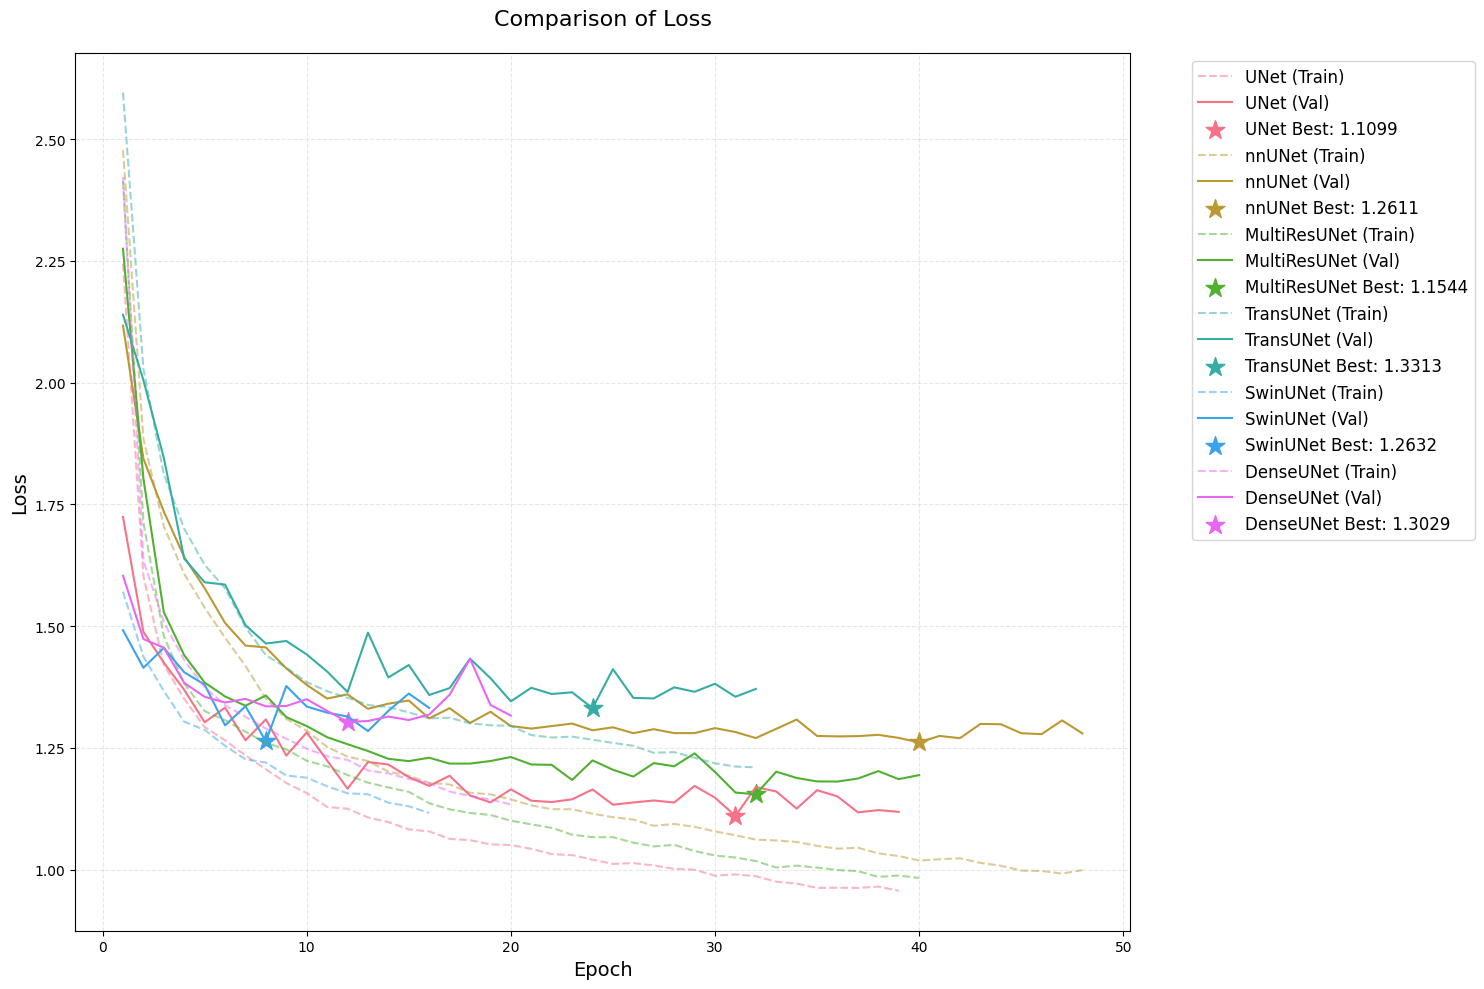

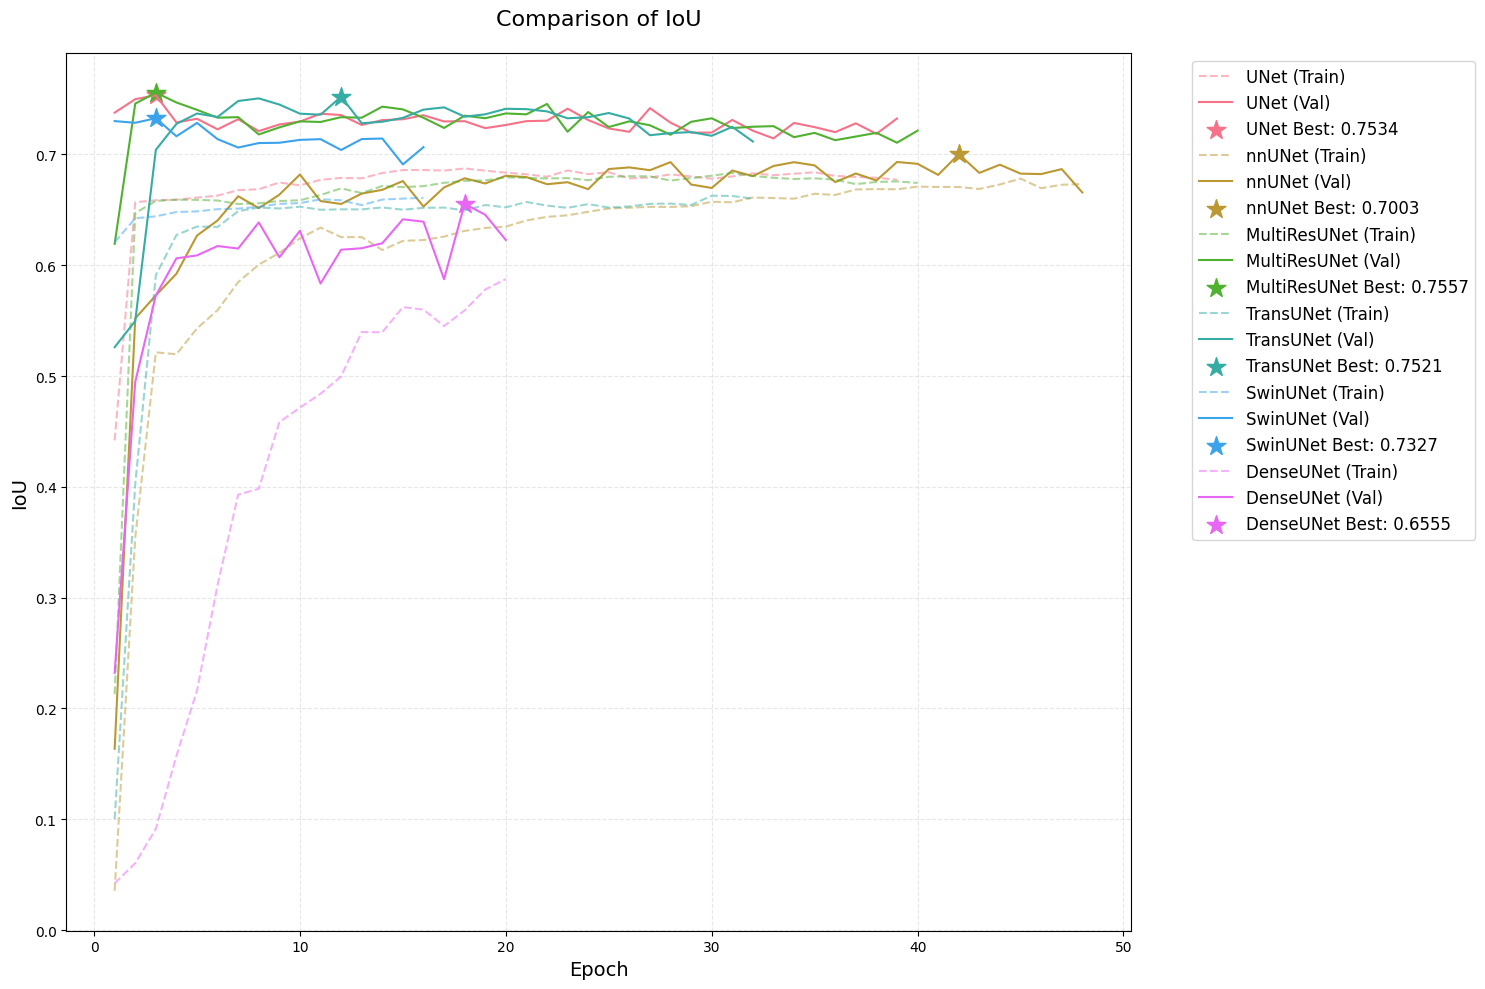

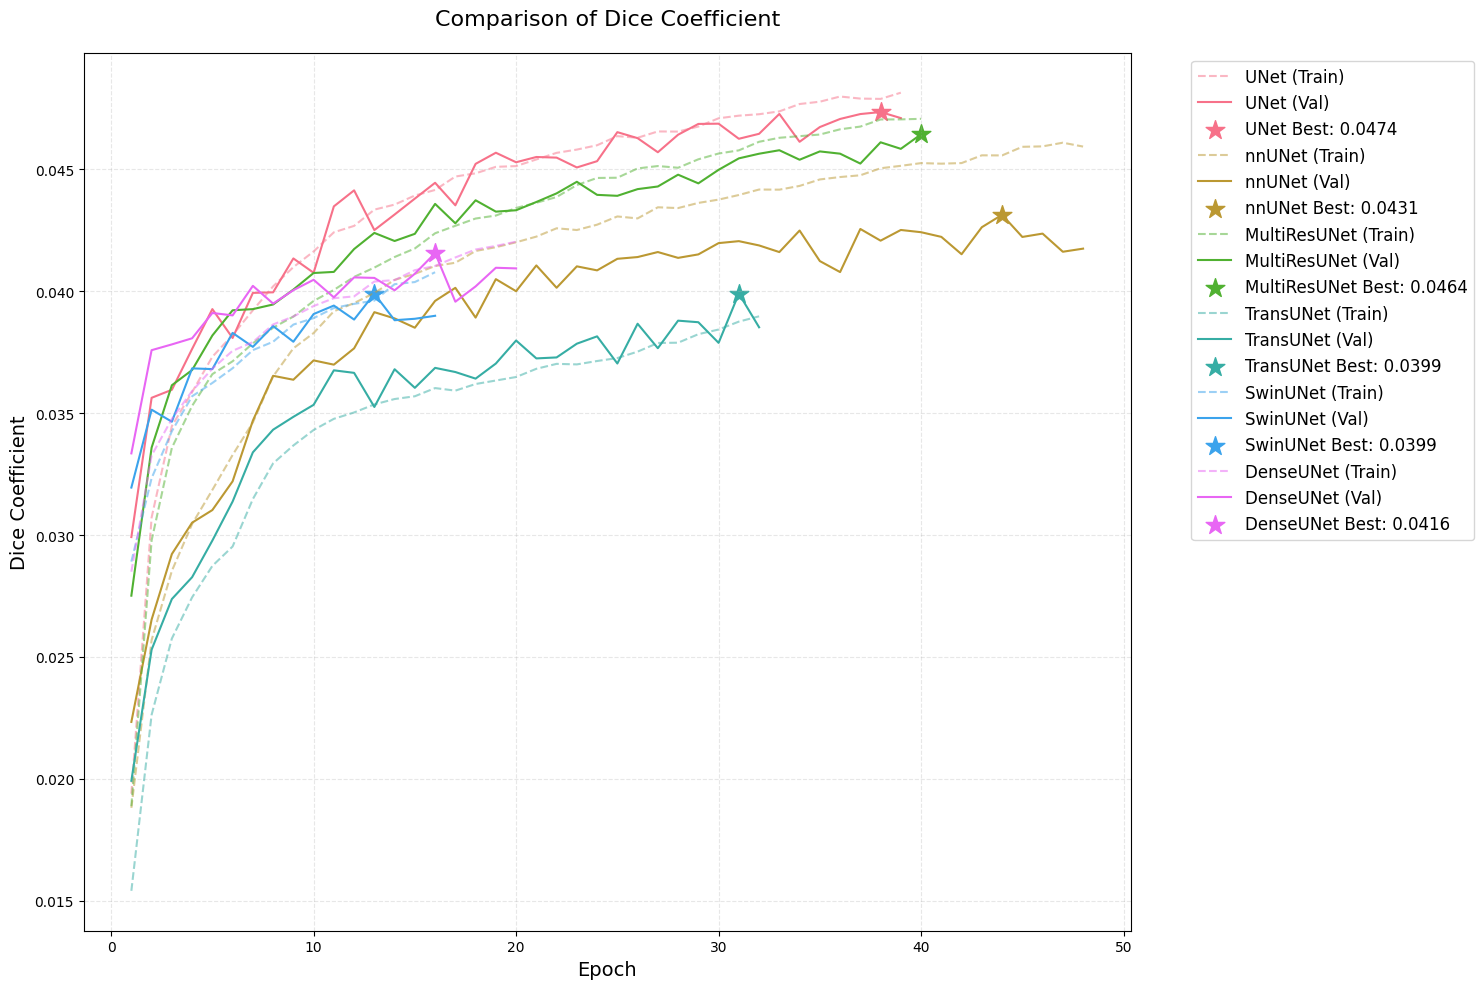

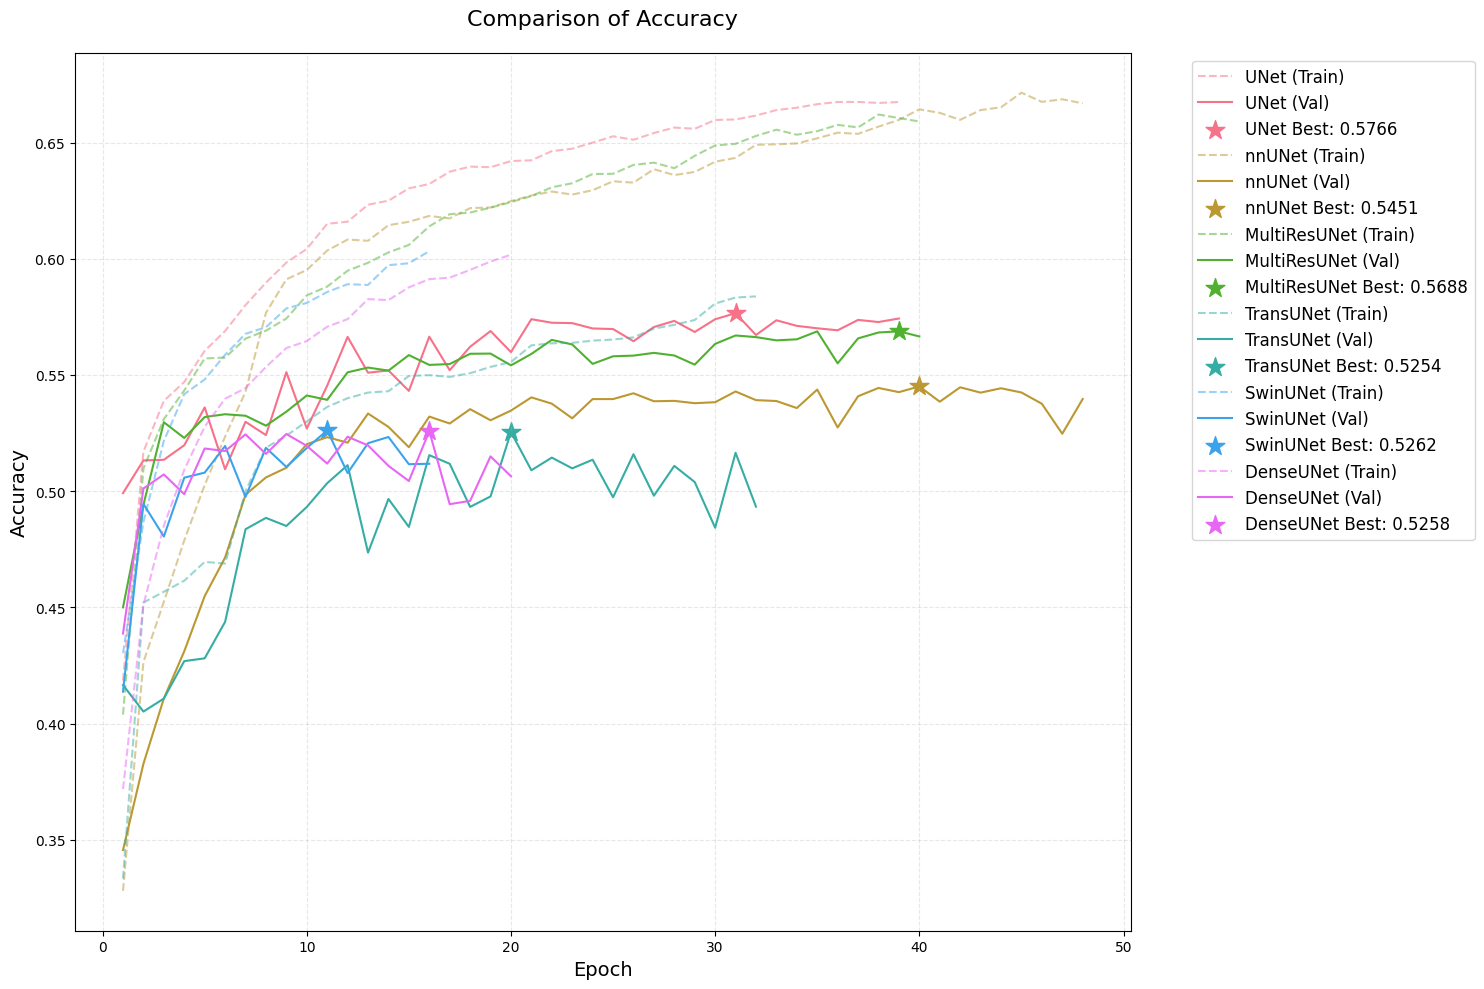


2. Generating performance comparison table...


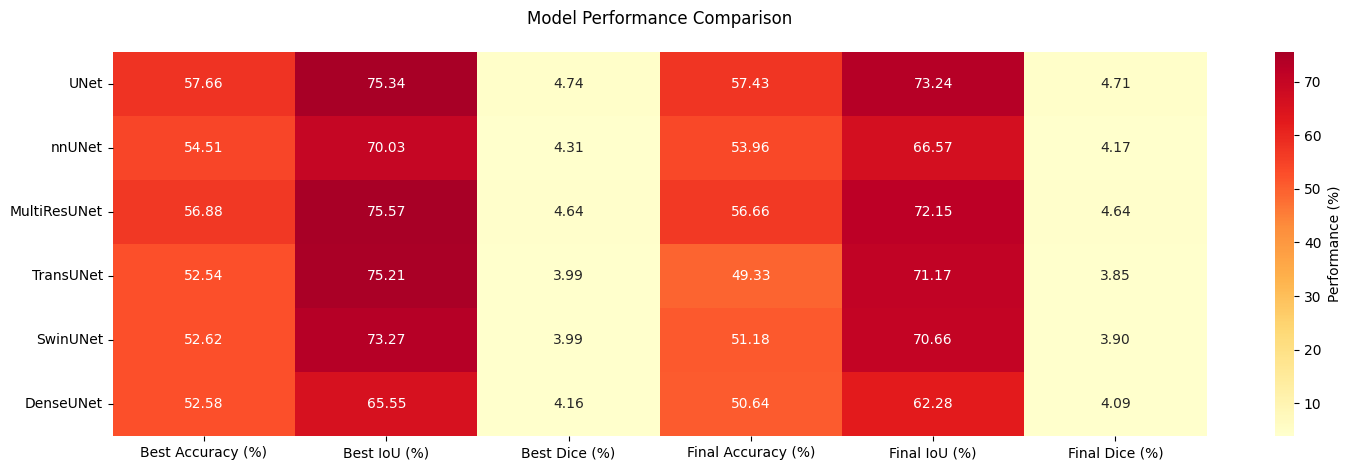


Detailed Model Comparison:
       Model  Best Accuracy (%)  Best IoU (%)  Best Dice (%)  Final Accuracy (%)  Final IoU (%)  Final Dice (%)  Training Time (min)  Total Parameters (M)  Epochs
        UNet              57.66         75.34           4.74               57.43          73.24            4.71               111.56                 31.04      39
      nnUNet              54.51         70.03           4.31               53.96          66.57            4.17                77.11                  8.11      48
MultiResUNet              56.88         75.57           4.64               56.66          72.15            4.64               124.20                  6.00      40
   TransUNet              52.54         75.21           3.99               49.33          71.17            3.85                19.61                 99.41      32
    SwinUNet              52.62         73.27           3.99               51.18          70.66            3.90                33.26                 35.79   

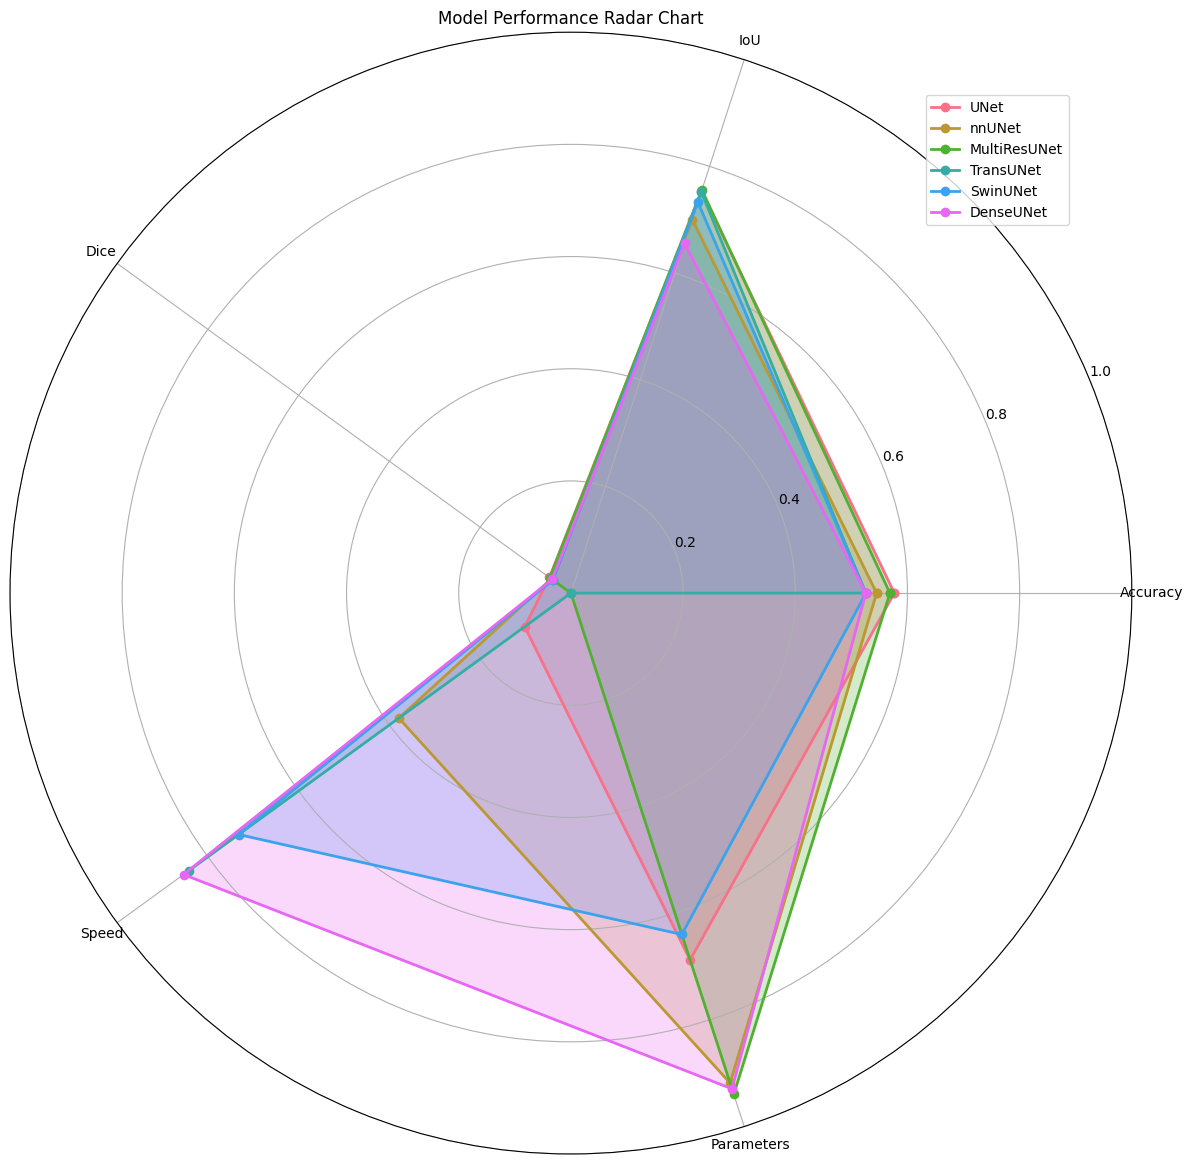

In [12]:
def main():
    train_dataset = BCSSDataset(
        TRAIN_IMAGE_PATH,
        TRAIN_MASK_PATH,
        transform=transforms_train
    )
    val_dataset = BCSSDataset(
        VAL_IMAGE_PATH,
        VAL_MASK_PATH,
        transform=transforms_val
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=6,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=6,
        pin_memory=True
    )
    
    results = run_comparison(train_loader, val_loader, device)
    
    summary_df = visualize_results(results)
    
    if summary_df is not None:
        summary_df.to_csv('model_comparison_results.csv', index=False)

if __name__ == '__main__':
    main()